# LendingClub Case Study

- Lending Club provides loans to borrowers, but a lot of borrowers default, that is they do not return the borrowed amount along with accumulated interest back to the lenders.
- Such defaults results in the monetary loss for the businesses or lenders.
- Hence, the purpose of this case study is to identify some of the prominent factors which can help understanding borrowers who have higher probability of defaulting.
- In this project, some of the factors have been analyzed and identified from the data and have been reported.

Note:
+ Headings in Red indicate Derived Variables
+ Heading in Green indicate either Segmented or Bivariate analysis
+ While, Black headings are generally used and for Univariate analysis
+ Insights or Notes are added after each piece of analysis

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

You should consider upgrading via the 'c:\users\prate\anaconda3\python.exe -m pip install --upgrade pip' command.


# Config

In [3]:
dataset_path = 'data/loan.csv'
data_dict_path = 'data/Data_Dictionary.xlsx'

# Custom Functions

In [4]:
def boxplot(data, x_col, y_col, x_label=None, y_label=None, title=None):
    "To plot boxplot for a numerical column against a categorical column"
    
    sns.boxplot(x=x_col, y=y_col, data=data)
    if x_label: plt.xlabel(x_label)
    if y_label: plt.ylabel(y_label)
    if title: plt.title(title)
    plt.show()

In [5]:
def get_category_distribution(data, col_name, count_col_name, normalize=True, order=None):
    "To get distributions of a categorical column."
    
    dist = loan_data[col_name]\
                .value_counts(normalize=True, dropna=False)\
                .to_frame().reset_index()

    dist.columns = [col_name, count_col_name]
    
    if order and type(order) == str:
        dist.sort_values(col_name, ascending=True, inplace=True, ignore_index=True)
        
    if order and type(order) == dict:
        dist['__order__'] = dist[col_name].apply(lambda x: order.get(x))
        dist.sort_values('__order__', inplace=True, ignore_index=True)
        del dist['__order__']
    
    return dist

# Load the Datasets

## Load the Loan dataset

In [6]:
loan_data = pd.read_csv(dataset_path)
loan_data.head()

C:\Users\prate\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (47) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


## Load the Data Dictionary

In [7]:
data_dict = pd.read_excel(data_dict_path, sheet_name='LoanStats', names=['column', 'description'])

data_dict.head(2)

,column,description
0,acc_now_delinq,The number of accounts on which the borrower i...
1,acc_open_past_24mths,Number of trades opened in past 24 months.


In [8]:
data_dict.shape

(117, 2)

# Sanity Check and Data Understanding

## Check if all the columns have descriptions

In [9]:
print("Following columns are not in data dictionary:\n")
set(list(loan_data.columns)) - set(data_dict['column'].tolist())

Following columns are not in data dictionary:



{'total_rev_hi_lim', 'verification_status_joint'}

In [10]:
print("Following columns are not in loan data:\n")
set(data_dict['column'].tolist()) - set(list(loan_data.columns))

Following columns are not in loan data:



{'fico_range_high',
 'fico_range_low',
 'last_fico_range_high',
 'last_fico_range_low',
 nan,
 'total_rev_hi_lim \xa0',
 'verified_status_joint'}

In [11]:
# check nan value
data_dict[data_dict['column'].isna()]

,column,description
115,NaN,NaN
116,NaN,* Employer Title replaces Employer Name for al...


Note: 
+ NaN is due to empty rows, which can be ignored
+ Rename "verified_status_joint" to "verification_status_joint"
+ Rename "total_rev_hi_lim \xa0" to "total_rev_hi_lim"

In [12]:
data_dict = data_dict[data_dict['column'].isna() == False]

In [13]:
data_dict[data_dict['column'] == 'verified_status_joint'] = 'verification_status_joint'
data_dict[data_dict['column'] == 'total_rev_hi_lim \xa0'] = 'total_rev_hi_lim'

In [14]:
print("Following columns are not in loan data after rename the two columns:\n")
set(data_dict['column'].tolist()) - set(list(loan_data.columns))

Following columns are not in loan data after rename the two columns:



{'fico_range_high',
 'fico_range_low',
 'last_fico_range_high',
 'last_fico_range_low'}

## Check the data types, nulls & statistics

In [15]:
# check the shape of the data i.e. number of rows and columns
loan_data.shape

(39717, 111)

There are 39,7171 number of rows and 111 columns

In [16]:
# get the statistics of the data
statistics = loan_data.describe(include='all')\
                .T.reset_index().rename(columns={'index': 'column'})

statistics.head(2)

,column,count,unique,top,freq,mean,std,min,25%,50%,75%,max
0,id,39717,NaN,NaN,NaN,683132,210694,54734,516221,665665,837755,1.0775e+06
1,member_id,39717,NaN,NaN,NaN,850464,265678,70699,666780,850812,1.04734e+06,1.31417e+06


In [17]:
# check the data types of the columns

summary = []
for col in loan_data.columns:
    summary.append((col, loan_data[col].isnull().sum(), str(loan_data[col].dtype)))

# convert the lists of lists to pandas dataframe
summary = pd.DataFrame(summary, columns=['column', 'num_nulls', 'dtype'])

# merge the data dictionary
summary = summary.merge(data_dict, on=['column'], how='left')

# merge the statistics
summary = summary.merge(statistics, on=['column'], how='left')

with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       'display.max_colwidth', None,
                       ):
    
    # do not display records which are completely blank
    display(summary[summary['num_nulls'] != loan_data.shape[0]].head(200))

,column,num_nulls,dtype,description,count,unique,top,freq,mean,std,min,25%,50%,75%,max
0,id,0,int64,A unique LC assigned ID for the loan listing.,3.97e+04,NaN,NaN,NaN,6.83e+05,2.11e+05,5.47e+04,5.16e+05,6.66e+05,8.38e+05,1.08e+06
1,member_id,0,int64,A unique LC assigned Id for the borrower member.,3.97e+04,NaN,NaN,NaN,8.5e+05,2.66e+05,7.07e+04,6.67e+05,8.51e+05,1.05e+06,1.31e+06
2,loan_amnt,0,int64,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.",3.97e+04,NaN,NaN,NaN,1.12e+04,7.46e+03,500,5.5e+03,1e+04,1.5e+04,3.5e+04
3,funded_amnt,0,int64,The total amount committed to that loan at that point in time.,3.97e+04,NaN,NaN,NaN,1.09e+04,7.19e+03,500,5.4e+03,9.6e+03,1.5e+04,3.5e+04
4,funded_amnt_inv,0,float64,The total amount committed by investors for that loan at that point in time.,3.97e+04,NaN,NaN,NaN,1.04e+04,7.13e+03,0,5e+03,8.98e+03,1.44e+04,3.5e+04
5,term,0,object,The number of payments on the loan. Values are in months and can be either 36 or 60.,39717,2,36 months,29096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,int_rate,0,object,Interest Rate on the loan,39717,371,10.99%,956,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,installment,0,float64,The monthly payment owed by the borrower if the loan originates.,3.97e+04,NaN,NaN,NaN,325,209,15.7,167,280,431,1.31e+03
8,grade,0,object,LC assigned loan grade,39717,7,B,12020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,sub_grade,0,object,LC assigned loan subgrade,39717,35,B3,2917,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Below are some quick observations on the data:

***id:*** Loan Id
+ Currently in int, should be in string

***member_id:*** Customer Id
+ Currently in int, should be in string
    
***loan_amnt:*** Loan amount customer applied for
+ Minimum loan amount is 500 (these could be small ticket loans, may be for the farmers) and maximum is 350,000
+ The mean loan amount is 11,219, while the median is 10,000, this indicates that the distribution is positively skewed
    + positive skew here mean there are more low amount loans than high amount loans
    
***funded_amnt:*** Total amount funded
+ Minimum amount is 500 while maximum is 350,000

***funded_amnt_inv:*** Total amount funded by the investor
+ Minimum value is 0, which indicates that there are loans which are not funded by investors. Could be due to risk factors
    
***term:*** duration of the loan within which it should be repayed
+ contains 2 unique values '36 months' & '60 months'
+ In most of the loans the payment is for'36 months'

***int_rate:*** Interest rate on the loan
+ should be int or float, but it is object type (due to presence of % sign at the end)
+ CHECK

***installment:*** Monthly amound to be paid against the loan
+ monthly installment ranges from 209 to 1,310
+ About 50% of the customers have monthly installment less than or equal to 280

***grade:*** Grade of the loan, generally grades are associated with risks involved based on borrower credit score. A generally is for least risk assets
+ has 7 distinct values
+ grade 'B' is the most frequent

***sub_grade:*** The high level grades like 'A' are sub divided, like 'A1', etc.
+ there are 35 distinct sub grades
+ the most frequent sub grade is 'B3'

***emp_title:*** Job title given by customer while applying for loan
+ There are 2,459 null values which could be from customers who are currently not employed could be students or business owner or home maker

***emp_length:*** Number of years of experience as an employee
+ It contains 11 distinct values and the most frequent one is "10+ years"
+ contains 1,075 nulls, which could be from students or business owner who never were employed

***home_ownership:*** home ownership status provided by customer should be one of RENT, OWN, MORTGAGE, OTHER
+ It contains 5 distinct values and RENT is the most frequent
+ Data dictionary mentions 4 types of statuses, but here there are 5 distinct values, CHECK

***annual_inc:*** Annual income of the customers
+ Minimum income is 4,000 and maximum is 6,000,000
+ Half of the people have income less than or equal to 59,000

***verification_status:*** Whether income is verified or not
+ contains 3 distinct values
+ according to the description there sould be only 2, CHECK
+ the most frequent value is "Not Verified"

***issue_d:*** Month-Year when loan was funded
+ contains 55 distinct values, need to CHECK if all values make sense
+ most frequent value is "Dec-11"

***loan_status:*** Status of the loan
+ contains 3 distinct values, need to CHECK those
+ most frequent is "Fully Paid"

***pymnt_plan:*** Indicates if payment plan is put in place.
+ contains single value 'n' and not much important

***url:*** URL of listings data
+ contains single value

***desc:*** Loan description prodivded by the customers
+ contains 12,940 nulls. Need to CHECK the loan status where description is provided and where it is not

***purpose:*** Loan category provided by the customer for loan
+ 14 distinct values
+ "Debt Consolidation" is the most frequent 

***zip_codes:*** First 3 digits of the zip code
+ 823 distinct values

***addr_state:*** State provided by customer
+ There are 50 distinct values
+ US has 51 states, so, most likely in 1 state they did not provide any loan

***dti:*** It is montly debt repayments to income ratio. Debt here does not include mortgages and the requested loan. Also, this ratio is then multiplied by 100 as it is always in percentage.
+ Minimum value is 0, indicating customers have 0 debt
+ Maximum is 30, which indicates there are customers who pay 30% of their income towards loan re-payment

***delinq_2yrs:*** Number of times a customer did not pay dues for more than 30 days
+ Minimum value is 0 indicating such customers made re-payments on time
+ Maximum value is 11, these customers might already have defaulted, need to CHECK
+ at least 75% of customers never had delinquency even once in last 2 years

***earliest_cr_line:*** Month when customers earliest credit line was opened
+ Contians 526 distinct values
+ most frequent is "Nov-98", about 370 customers had their reported first loan in Nov 1998

***inq_last_6mths:*** Number of inquiries made in last 6 months. Inquiries does not include auto and mortgage
+ Minimum value is 0, while 8 is maximum
+ about 75% of the customers have number of inquiries less than or equal to 1

***mths_since_last_delinq:*** Months since last delinquency
+ Minimum value is ranges between 0 i.e. they yet have not made any delinquency, while maximum is 120 i.e. thier last delinquency was 10 years back
+ About 25% of the customers have not made a single delay in payment in last 18 months
+ For most of the customers this data is missing (25,682 Nulls) -- need to CHECK if any loan was provided to them or not

***mths_since_last_record:*** Months since there has been any public record. Public record could be related to marriage or any criminal proceedings and hence could be a good indicator of default. CHECK
+ Values range between 0 and 129
+ About 50% of the customers do not have updated public record in last 90 months
+ For most of the customers this column is blank (36,931 Nulls), this could indicate that there was no data collected on them or they do not have any public record, which could be a good thing

***open_acc:*** Number of open credit lines of a customer. Can CHECK its correlation with dti and default as high credit line could indicate high borrowed amount and difficult in paying back.
+ Values ranges between 2 and 44
+ All the customers have at least 2 credit accounts
+ About 50% of the customers have more than 9 credit accounts

***pub_rec:*** Number of derogatory public records could have some relationship with default.
+ Values range between 0 and 4
+ At least 75% of the customers do not have any derogatory public records

***revol_bal:*** Is the amount which was remained unpaid last months and propogated to current month.
+ Values ranges between 0 and 150,000
+ Mean amount that remains unpaid is 15,900

***revol_util:*** The amount of money customer is using against all the available credit. It is in percentage.
+ Due to "percentage sign", it is coming out as categorical variable needs to be fixed
+ FIX

***total_acc:*** Total credit lines a customer had.
+ Borrowers have minimum 2 credit lines and maximum 90.
+ 90 credit lines seems to be an OUTLIER value, needs to CHECKed
+ About 50% of the customers have 20 or less credit lines

***initial_list_status:*** Initial status of the application 
+ Categorical column but contains only single unique value "f"
+ Since there is no variation in the dataset, it is not of any use

***out_prncp:*** Total remaining principal amount
+ Values range between 0 and 6,310
+ At least 75% of the customers do no have any outstanding principal amount

***out_prncp_inv:*** Total remaining principal amount for the amount funded by investors
+ Min value is 0 and max is 6,310
+ At least 75% of the customers do no have any outstanding principal amount

***total_pymnt:*** Total payment received for total funded amount
+ Values range between 0 and 58,600

***total_pymnt_inv:*** Total payment received for total investor funded amount
+ Values range between 0 and 58,600

***total_rec_prncp:*** Total principal amount received till date
+ Minimum value is 0 indicating there are customers who have not repayed any amount yet
+ Maximum value is 35,000

***total_rec_int:*** Total interest received till date
+ Minimum interest received is 0, while maximum is 23,600

***total_rec_late_fee:*** Total late fee received till date
+ Values range between 0 and 180
+ At least 75% of the customers never paid late fee

***recoveries:*** Once customer was charged-off, any amount recovered post that
+ Values range between 0 and 29,600

***collection_recovery_fee:*** Once customer was charged-off, recovery fee collected post that
+ values range between 0 and 7,000

***last_pymnt_d:*** Last month the payment was received
+ Categorical (month-year) column with 101 distinct values
+ Most frequent is "May-16"
+ There are 71 nulls, could indicate, about 71 customers never made even a single payment

***last_pymnt_amnt:*** Last total amount paid by customers
+ minimum value is 0 and maximum is 36,100

***next_pymnt_d:*** Month next payment is scheduled for
+ Most of the values are Null, need to CHECK why, it could be most customers cleared their loan
+ Contains 2 distinct values, need to check those
+ "Jun-16" is the most frequent (1,125 records)

***last_credit_pull_d:*** The latest month when the credit was pulled
+ Categorical (month-year) column with 106 distinct values
+ "May-16" is the most frequent with 10,308 frequency

***collections_12_mths_ex_med:*** Number of times payment were received in last 12 months (excluding medical)
+ This column contains only 0
+ But, there are 56 Nulls, could be no payments were made by these customers -- CHECK

***policy_code:*** Public policy code
+ Only contains policy code = 1

***application_type:*** Is the loan Individual or Joint type
+ All are "individual" loans

***acc_now_delinq:*** number of accountss on which customer is now delinquent
+ all the values are 0 -- which could be an error or missing data. As we saw above some customers did not made last month payments

***chargeoff_within_12_mths:*** Number of charge-offs in last 12 months
+ Entire column only contain 0
+ 56 values are Null -- these could be the charged off customers

***pub_rec_bankruptcies:*** Number of public recorded bankrupcies
+ Values are in range of 0 to 2
+ But for most records it is 0
+ There are 697 Nulls, for these there could be no info available

**REST OF THE COLUMNS ARE NULL OR CONTAINS SAME VALUES ACROSS ALL RECORDS**

## Fix the observed discrepancies & perform Univariate analysis

### Convert 'id' from int to string

In [18]:
loan_data['id'] = loan_data['id'].apply(str)
loan_data['id'].head(5)

0    1077501
1    1077430
2    1077175
3    1076863
4    1075358
Name: id, dtype: object

In [19]:
print("Total number of loan applications: {:,}".format(loan_data['id'].nunique()))

Total number of loan applications: 39,717


### Convert 'member_id' from int to string

In [20]:
loan_data['member_id'] = loan_data['member_id'].apply(str)
loan_data['member_id'].head(5)

0    1296599
1    1314167
2    1313524
3    1277178
4    1311748
Name: member_id, dtype: object

In [21]:
print("Total number of applicants/borrowers: {:,}".format(loan_data['member_id'].nunique()))

Total number of applicants/borrowers: 39,717


+ Note: each record is at borrower level, where each borrower has a single loan

### Check the distribution of loan_status

In [22]:
ls_dist = get_category_distribution(loan_data, 'loan_status', 'perc_loans', normalize=True, order=None)
ls_dist.head()

,loan_status,perc_loans
0,Fully Paid,0.829620
1,Charged Off,0.141677
2,Current,0.028703


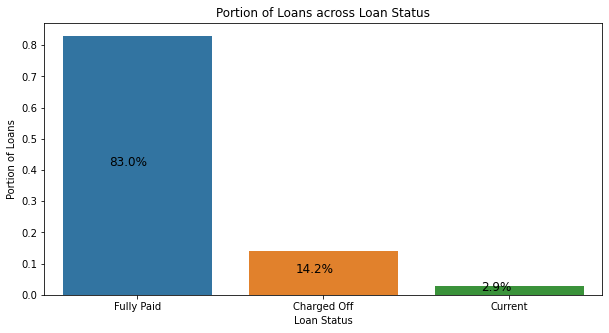

In [23]:
# bar plot
fig, axs = plt.subplots(1, 1)

sns.barplot(x='loan_status', y='perc_loans', data=ls_dist, ax=axs)

plt.xlabel('Loan Status')
plt.ylabel('Portion of Loans')
plt.title("Portion of Loans across Loan Status")

for idx, row in ls_dist.iterrows():
    plt.text(idx-.15, row['perc_loans']/2, "{:.1%}".format(row['perc_loans']), fontdict=dict(size='large'))
    
fig.set_size_inches((10, 5))
plt.show()

Insights:
+ 83% of the Loans are Fully-paid
+ 3% of the Loans are Active
+ While, 14.2% of the Loans have been Charged-Off i.e. there is some default and payment is not made at least of last 1 month

### Check the distribution of loan_amnt

C:\Users\prate\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


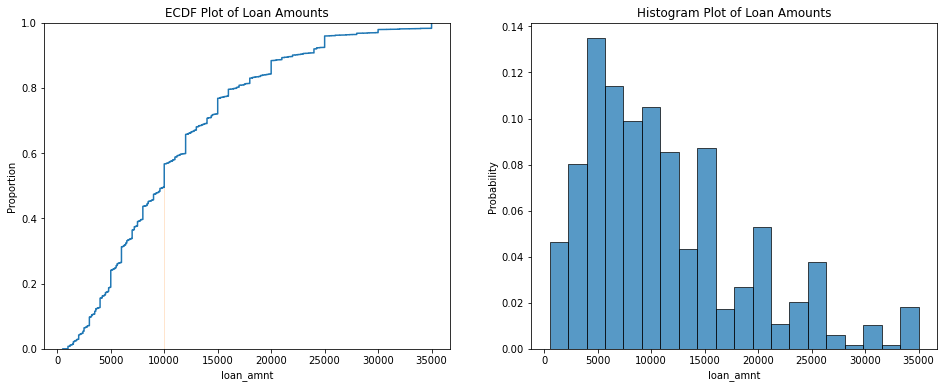

In [24]:
fig, axs = plt.subplots(1,2)

median = loan_data['loan_amnt'].median()

# get ecdf plot
sns.ecdfplot(loan_data['loan_amnt'], ax=axs[0])
sns.lineplot([median, median], [0, 0.5], ax=axs[0])
axs[0].set_title('ECDF Plot of Loan Amounts')

# get histogram plot
sns.histplot(loan_data['loan_amnt'], bins=20, stat='probability', ax=axs[1])
axs[1].set_title('Histogram Plot of Loan Amounts')

fig.set_size_inches((16, 6))
plt.show()

Note:
- Roughly 80% of the loans are of less than 20,000 in value
- 20% of loans are below 5,000 in value
- Loam amount is positively skewed i.e. more small ticket loans are issues than large ticket loans
- 50% of the loans are roughly of value less than or equal to 10,000

### <font color='green'> Segmented Analysis: loan amount vs. loan status </font>

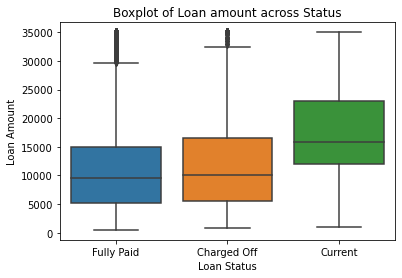

In [25]:
boxplot(loan_data, 'loan_status', 'loan_amnt', 'Loan Status', 'Loan Amount', 'Boxplot of Loan amount across Status')

Insights:
+ Current Loan amounts are much higher than Charged-Off and Fully-paid amount
+ While, Fully-paid and Charged-off are almost same

### Check the distribution of funded_amnt

C:\Users\prate\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


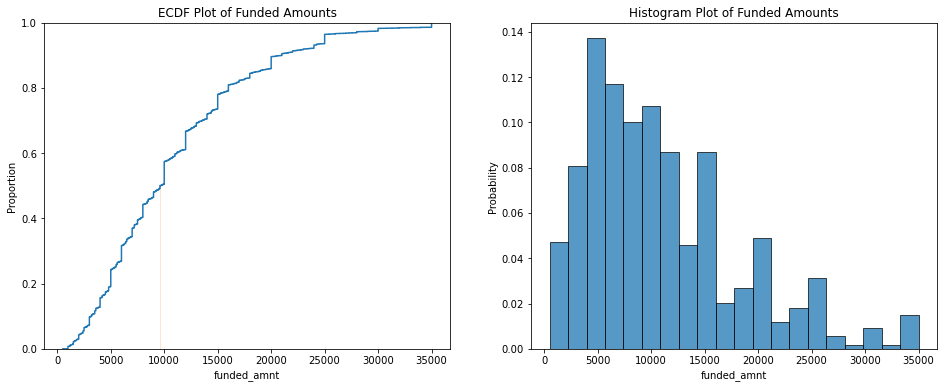

In [26]:
fig, axs = plt.subplots(1,2)

median = loan_data['funded_amnt'].median()

# get ecdf plot
sns.ecdfplot(loan_data['funded_amnt'], ax=axs[0])
sns.lineplot([median, median], [0, 0.5], ax=axs[0])
axs[0].set_title('ECDF Plot of Funded Amounts')

# get histogram plot
sns.histplot(loan_data['funded_amnt'], bins=20, stat='probability', ax=axs[1])
axs[1].set_title('Histogram Plot of Funded Amounts')

fig.set_size_inches((16, 6))
plt.show()

Note:
- The distribution of funded amount is same as Loan amount, looks like all the loans were completely funded (need to verify that).

### <font color='red'> Business Driven Derived variable: funded_amnt to loan_amnt Ratio </font>

In [27]:
# calculate variable funded_amnt to loan_amnt
loan_data['funded_amnt_ratio'] = loan_data['funded_amnt'] / loan_data['loan_amnt']
loan_data['funded_amnt_ratio'].head(5)

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: funded_amnt_ratio, dtype: float64

Text(0.5, 1.0, 'Histogram Plot of Funded Amounts')

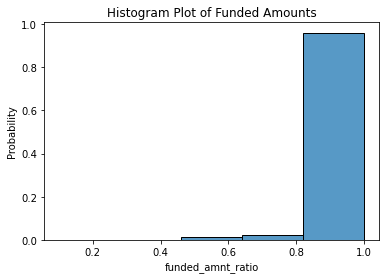

In [28]:
# get histogram plot
sns.histplot(loan_data['funded_amnt_ratio'], bins=5, stat='probability')
plt.title('Histogram Plot of Funded Amounts')

### <font color='red'> Data Driven derived variable: boolean if loan fully funded or not </font>

In [29]:
# create a flag in loan was fully-funded or not
loan_data['is_fully_funded_amnt'] = loan_data['funded_amnt_ratio'].apply(lambda x: 'Fully funded' if x == 1. else 'Partially funded')

In [30]:
is_funded_dist = get_category_distribution(loan_data, 'is_fully_funded_amnt', 'perc_loans', normalize=True, order=None)
is_funded_dist.head()

,is_fully_funded_amnt,perc_loans
0,Fully funded,0.953446
1,Partially funded,0.046554


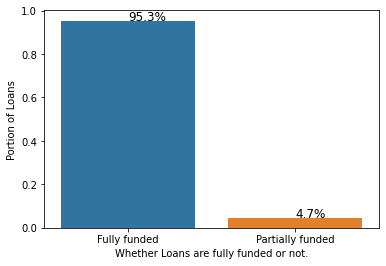

In [31]:
# bar plot
sns.barplot(x='is_fully_funded_amnt', y='perc_loans', data=is_funded_dist)
plt.xlabel('Whether Loans are fully funded or not.')
plt.ylabel('Portion of Loans')

for idx, row in is_funded_dist.iterrows():
    plt.text(idx, row['perc_loans'], "{:.1%}".format(row['perc_loans']), fontdict=dict(size='large'))

plt.show()

Note:
- About 4.7% of the loans are not fully funded, which amounts to 1,849 loans

### Check the distribution of funded_amnt_inv

C:\Users\prate\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


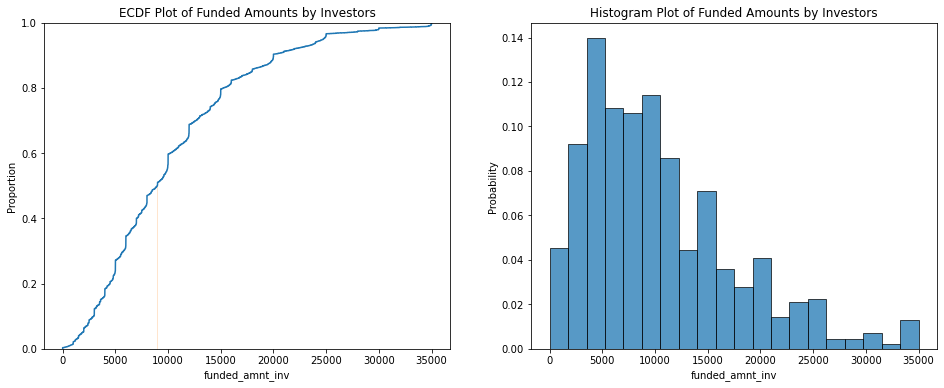

In [32]:
fig, axs = plt.subplots(1,2)

median = loan_data['funded_amnt_inv'].median()

# get ecdf plot
sns.ecdfplot(loan_data['funded_amnt_inv'], ax=axs[0])
sns.lineplot([median, median], [0, 0.5], ax=axs[0])
axs[0].set_title('ECDF Plot of Funded Amounts by Investors')

# get histogram plot
sns.histplot(loan_data['funded_amnt_inv'], bins=20, stat='probability', ax=axs[1])
axs[1].set_title('Histogram Plot of Funded Amounts by Investors')

fig.set_size_inches((16, 6))
plt.show()

Note:
+ Plot is very similar to Loan Amount and Funded Amount, so, it could be most loans are funded. Need to check

### <font color='red'> Data Driven derived variable: funded_amnt_inv to loan_amnt Ratio </font>

In [33]:
# calculate variable funded_amnt_inv to loan_amnt
loan_data['funded_amnt_inv_ratio'] = loan_data['funded_amnt_inv'] / loan_data['loan_amnt']
loan_data['funded_amnt_inv_ratio'].head(5)

0    0.995
1    1.000
2    1.000
3    1.000
4    1.000
Name: funded_amnt_inv_ratio, dtype: float64

Text(0.5, 1.0, 'Histogram Plot of Funded Amounts by Investors')

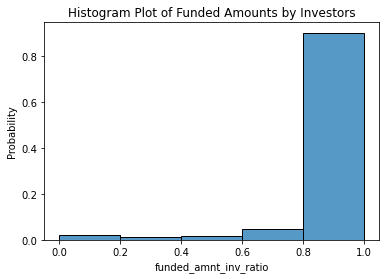

In [34]:
# get histogram plot
sns.histplot(loan_data['funded_amnt_inv_ratio'], bins=5, stat='probability')
plt.title('Histogram Plot of Funded Amounts by Investors')

Note:
- There is more mass on the lower side, indicating there are loans which are not funded or less funded by investors.

### <font color='red'> Data Driven derived variable: boolean if loan fully funded or not by investors </font>

In [35]:
# create a flag in loan was fully-funded or not
loan_data['is_fully_funded_amnt_inv'] = loan_data['funded_amnt_inv_ratio'].apply(lambda x: 'Fully funded' if x >= 1. else "Partially funded")

In [36]:
is_funded_dist = get_category_distribution(loan_data, 'is_fully_funded_amnt_inv', 'perc_loans', normalize=True, order=None)
is_funded_dist.head()

,is_fully_funded_amnt_inv,perc_loans
0,Partially funded,0.508321
1,Fully funded,0.491679


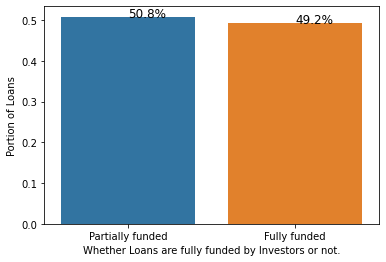

In [37]:
# bar plot
sns.barplot(x='is_fully_funded_amnt_inv', y='perc_loans', data=is_funded_dist)
plt.xlabel('Whether Loans are fully funded by Investors or not.')
plt.ylabel('Portion of Loans')

for idx, row in is_funded_dist.iterrows():
    plt.text(idx, row['perc_loans'], "{:.1%}".format(row['perc_loans']), fontdict=dict(size='large'))

plt.show()

In [38]:
print("Percentage of Loans not fully funded by investors: {:.2%}".format(19528/(19528+20189)))

Percentage of Loans not fully funded by investors: 49.17%


In [39]:
not_funded = loan_data[loan_data['funded_amnt_inv_ratio'] == 0].shape[0]
print("Percentage of Loans not funded by investors at all: {:.2%}".format(not_funded/loan_data.shape[0]))

Percentage of Loans not funded by investors at all: 0.32%


Note:
+ About 49% of the loans are not fully funded by investors
+ 0.32% of of the loans are not at all funded by investors

### Check how the loan term are distributed

In [40]:
term_dist = get_category_distribution(loan_data, 'term', 'perc_loans', normalize=True, order=None)
term_dist.head()

,term,perc_loans
0,36 months,0.732583
1,60 months,0.267417


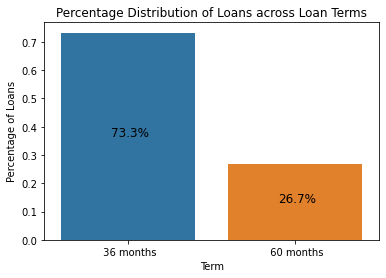

In [41]:
sns.barplot(x='term', y='perc_loans', data=term_dist)
plt.xlabel('Term')
plt.ylabel('Percentage of Loans')
plt.title("Percentage Distribution of Loans across Loan Terms")

for idx, row in term_dist.iterrows():
    plt.text(idx-.1, row['perc_loans']/2., "{:.1%}".format(row['perc_loans']), fontdict=dict(size='large'))

plt.show()

Note:
- 73% of the loans are of 36 months duration, while rest are of 60 months

### <font color='green'> Bivariate Analysis: loan term vs. loan status </font>

In [42]:
crosstab_purpose_status = pd.crosstab(index=loan_data['term'], columns=loan_data['loan_status'], normalize=0).reset_index()
crosstab_purpose_status

loan_status,term,Charged Off,Current,Fully Paid
0,36 months,0.110909,0.000000,0.889091
1,60 months,0.225967,0.107335,0.666698


(array([0, 1]), <a list of 2 Text major ticklabel objects>)

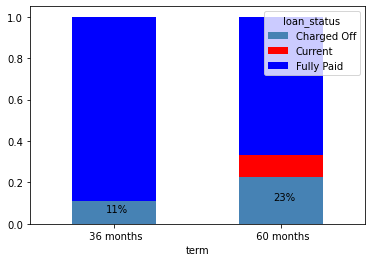

In [43]:
#create stacked bar chart
crosstab_purpose_status.set_index('term').plot(kind='bar', stacked=True, color=['steelblue', 'red', 'blue'])

for idx, row in crosstab_purpose_status.iterrows():
    plt.text(idx-.05, row['Charged Off']/2, "{:.0%}".format(row['Charged Off']))

plt.xticks(rotation=0)

Insights:
+ About 89% of the "36 months" term loans have been fully-paid, while only 11% are charged-off
+ 22% of "60 months" term loans are charged-off, which is 11% higher than "36 months" term

So, longer term loans are prone to higher default

### Fix int_rate
contains percentage sign remove it and convert it into float

In [44]:
loan_data['int_rate'] = loan_data['int_rate'].apply(lambda s: float(s.replace('%', '').strip()))
loan_data['int_rate'].head(5)

0    10.65
1    15.27
2    15.96
3    13.49
4    12.69
Name: int_rate, dtype: float64

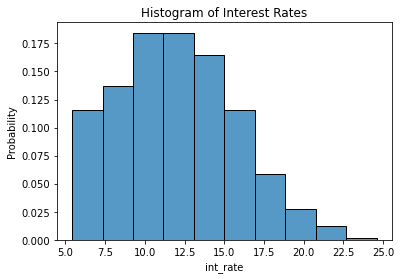

In [45]:
sns.histplot(loan_data['int_rate'], stat='probability', bins=10)
plt.title('Histogram of Interest Rates')
plt.show()

Note:
- Highest number of loans are given at interest rate of 10% to 15%
- Least loans are given at a interest rate of over 20%

### <font color='green'> Segmented Analysis: loan interest rate vs. loan status </font>

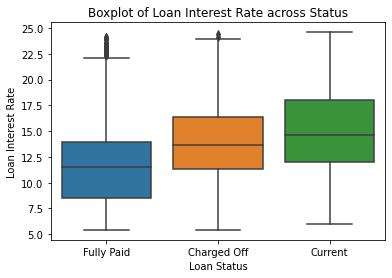

In [46]:
boxplot(loan_data, 'loan_status', 'int_rate', 'Loan Status', 'Loan Interest Rate', 'Boxplot of Loan Interest Rate across Status')

In [47]:
loan_data.groupby('loan_status').agg({'int_rate': 'median'})

,int_rate
loan_status,
Charged Off,13.61
Current,14.65
Fully Paid,11.49


In [48]:
(13.57 - 11.49) / 11.49 * 100

18.102697998259355

In [49]:
(14.56 - 11.49) / 11.49 * 100

26.718885987815494

Insights:
+ Loans which are Charged-off have 18.1% higher interest rate than the ones Fully-Paid

### Check the distribution of installment

Median of Installments is: 280.22


C:\Users\prate\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


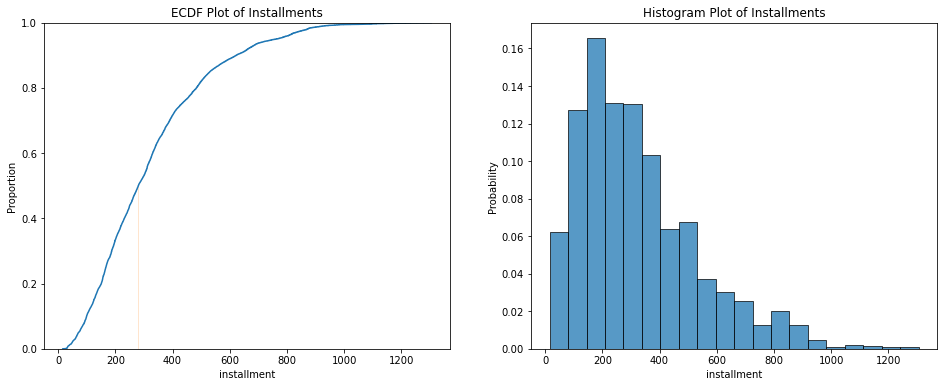

In [50]:
fig, axs = plt.subplots(1,2)

median = loan_data['installment'].median()
print("Median of Installments is: {:.2f}".format(median))

# get ecdf plot
sns.ecdfplot(loan_data['installment'], ax=axs[0])
sns.lineplot([median, median], [0, 0.5], ax=axs[0])
axs[0].set_title('ECDF Plot of Installments')

# get histogram plot
sns.histplot(loan_data['installment'], bins=20, stat='probability', ax=axs[1])
axs[1].set_title('Histogram Plot of Installments')

fig.set_size_inches((16, 6))
plt.show()

Note:
- The distribution of installments is positively skewed, meaning, most of the payments are of lower value
- About, 50% of the installments are roughly less than equal to 280

### <font color='green'> Segmented Analysis: Monthly Installments vs. loan status </font>

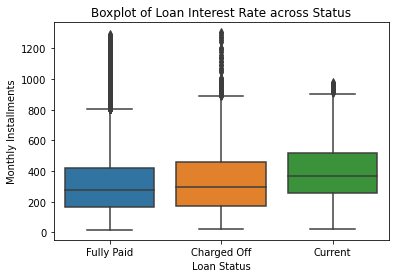

In [51]:
boxplot(loan_data, 'loan_status', 'installment', 'Loan Status', 'Monthly Installments', 'Boxplot of Loan Interest Rate across Status')

Insights:
+ Fully-paid and Charged-off loans have almost similar median monthly installment

### Check the distribution of grades

In [52]:
grade_dist = get_category_distribution(loan_data, 'grade', 'perc_loans', normalize=True, order='grade')
grade_dist.head()

,grade,perc_loans
0,A,0.253921
1,B,0.302641
2,C,0.203893
3,D,0.133620
4,E,0.071556


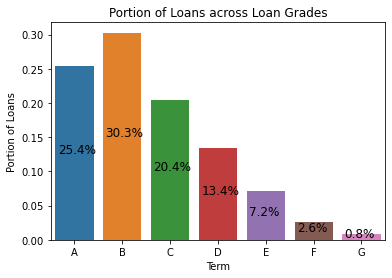

In [53]:
# bar plot
sns.barplot(x='grade', y='perc_loans', data=grade_dist)
plt.xlabel('Term')
plt.ylabel('Portion of Loans')
plt.title("Portion of Loans across Loan Grades")

for idx, row in grade_dist.iterrows():
    plt.text(idx-.35, row['perc_loans']/2., "{:.1%}".format(row['perc_loans']), fontdict=dict(size='large'))

plt.show()

Note:
+ About 30% of the loans are of highest grade
+ 23% of the loans have grade D or below

### <font color='green'> Bivariate Analysis: Loan Grade vs. Status </font>

In [54]:
crosstab_grade_status = pd.crosstab(index=loan_data['grade'], columns=loan_data['loan_status'], normalize=0).reset_index()
crosstab_grade_status

loan_status,grade,Charged Off,Current,Fully Paid
0,A,0.059693,0.003966,0.936341
1,B,0.118552,0.028702,0.852745
2,C,0.166337,0.032601,0.801062
3,D,0.210665,0.041832,0.747503
4,E,0.251583,0.062984,0.685433
5,F,0.304099,0.069590,0.626311
6,G,0.319620,0.053797,0.626582


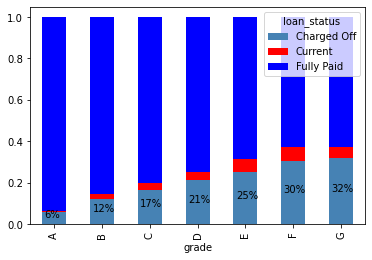

In [55]:
#create stacked bar chart
crosstab_grade_status.set_index('grade').plot(kind='bar', stacked=True, color=['steelblue', 'red', 'blue'])

for idx, row in crosstab_grade_status.iterrows():
    plt.text(idx-.2, row['Charged Off']/2, "{:.0%}".format(row['Charged Off']))

Insights:
+ Lower grades have higher percentage of Charged-off loan status
+ Grade 'G' loans have charge-off as high as 32%

### Check the distribution of sub-grades

In [56]:
sub_grade_dist = get_category_distribution(loan_data, 'sub_grade', 'perc_loans', normalize=True, order='sub_grade')
sub_grade_dist.head(2)

,sub_grade,perc_loans
0,A1,0.028678
1,A2,0.037969


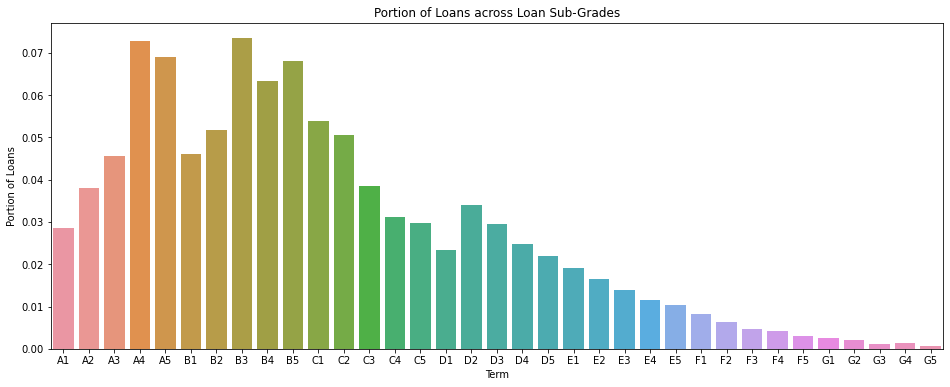

In [57]:
# bar plot

fig, axs = plt.subplots(1,1)

sns.barplot(x='sub_grade', y='perc_loans', data=sub_grade_dist, 
            order=sorted(sub_grade_dist['sub_grade'].unique()), ax=axs)

plt.xlabel('Term')
plt.ylabel('Portion of Loans')
plt.title("Portion of Loans across Loan Sub-Grades")

fig.set_size_inches((16, 6))
plt.show()

Note:
+ Even among the higest grade 'A', the 'A1', has the lowest number of loans
+ Similarly, among grade 'B', 'B1' has the lowest

### <font color='green'> Bivariate Analysis: Loan Sub Grade vs. Status </font>

In [58]:
crosstab_grade_status = pd.crosstab(index=loan_data['sub_grade'], columns=loan_data['loan_status'], normalize=0).reset_index()
crosstab_grade_status.head(2)

loan_status,sub_grade,Charged Off,Current,Fully Paid
0,A1,0.026339,0.0,0.973661
1,A2,0.049072,0.0,0.950928


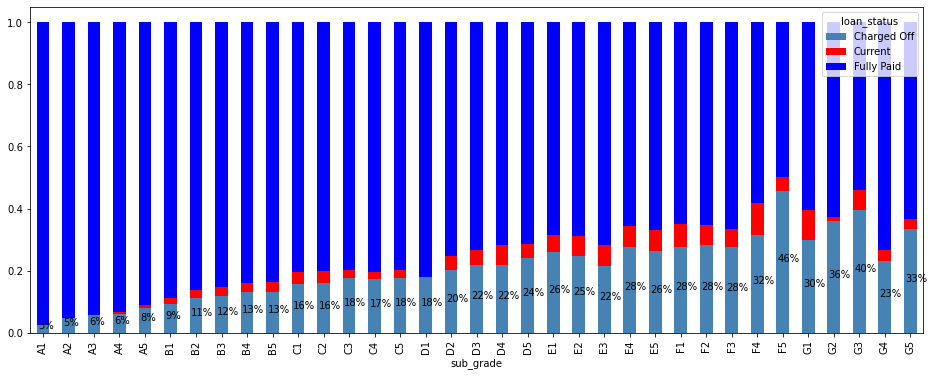

In [59]:
#create stacked bar chart

axes = crosstab_grade_status.set_index('sub_grade').plot(kind='bar', stacked=True, color=['steelblue', 'red', 'blue'])

# extract the figure object
fig = axes.get_figure()

for idx, row in crosstab_grade_status.iterrows():
    plt.text(idx-.2, row['Charged Off']/2, "{:.0%}".format(row['Charged Off']))
    
fig.set_size_inches((16, 6))
plt.show()

Insights:
+ Across sub-grades also we can obser that lower the grade the higher the number of defaults

### Word Cloud  of the titles (emp_title)

In [60]:
# display 10 titles
for idx, val in enumerate(loan_data['emp_title']):
    print(val)
    if idx>=10: break

nan
Ryder
nan
AIR RESOURCES BOARD
University Medical Group
Veolia Transportaton
Southern Star Photography
MKC Accounting 
nan
Starbucks
Southwest Rural metro


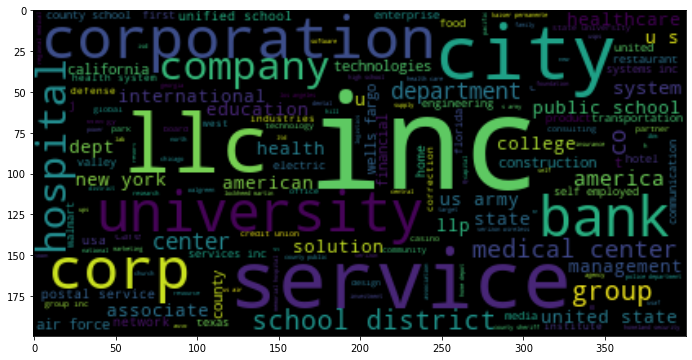

In [61]:
# get the text for word cloud
text = " ".join(loan_data[loan_data['emp_title'].isnull() == False]['emp_title']).lower()

# plot the word cloud
fig, axs = plt.subplots(1, 1)
cloud = WordCloud(max_words=200, stopwords=set(STOPWORDS))
cloud.generate(text)
fig.set_size_inches((16, 6))
plt.imshow(cloud, interpolation='bilinear')

Note:
Some of the top words in titles are:
+ service
+ llc
+ inc
+ city
+ university
+ school
+ company

### Check the distribution of emp_length

In [62]:
order = {val:i for i, val in enumerate(['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', 
         '6 years', '7 years', '8 years', '9 years', '10+ years', 'nan'])}

emp_len_dist = get_category_distribution(loan_data, 'emp_length', 'perc_loans', True, order)
emp_len_dist.head(2)

,emp_length,perc_loans
0,< 1 year,0.115391
1,1 year,0.081577


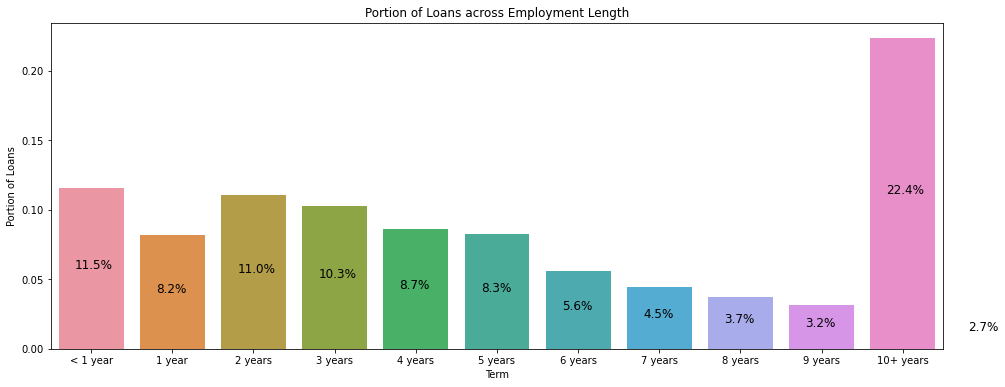

In [63]:
# bar plot

fig, axs = plt.subplots(1,1)

sns.barplot(x='emp_length', y='perc_loans', data=emp_len_dist, ax=axs)

plt.xlabel('Term')
plt.ylabel('Portion of Loans')
plt.title("Portion of Loans across Employment Length")

for idx, row in emp_len_dist.iterrows():
    plt.text(idx-.2, row['perc_loans']/2., "{:.1%}".format(row['perc_loans']), fontdict=dict(size='large'))
    
fig.set_size_inches((16, 6))
plt.show()

Note:
+ More than 20% of the loans belong to customers with more than 10 years of service
+ There are less customers with more service experience as compared to less experience customers, which could be due to higher incomes and less requirement of loans

### <font color='green'> Bivariate Analysis: Employment Length vs. Loan Status </font>

In [64]:
crosstab_emplen_status = pd.crosstab(index=loan_data['emp_length'], columns=loan_data['loan_status'], normalize=0).reset_index()

crosstab_emplen_status['order'] = crosstab_emplen_status['emp_length'].apply(lambda x: order.get(x))
crosstab_emplen_status.sort_values('order', inplace=True, ignore_index=True)

del crosstab_emplen_status['order']

crosstab_emplen_status.head(2)

loan_status,emp_length,Charged Off,Current,Fully Paid
0,< 1 year,0.139428,0.016365,0.844207
1,1 year,0.140741,0.021914,0.837346


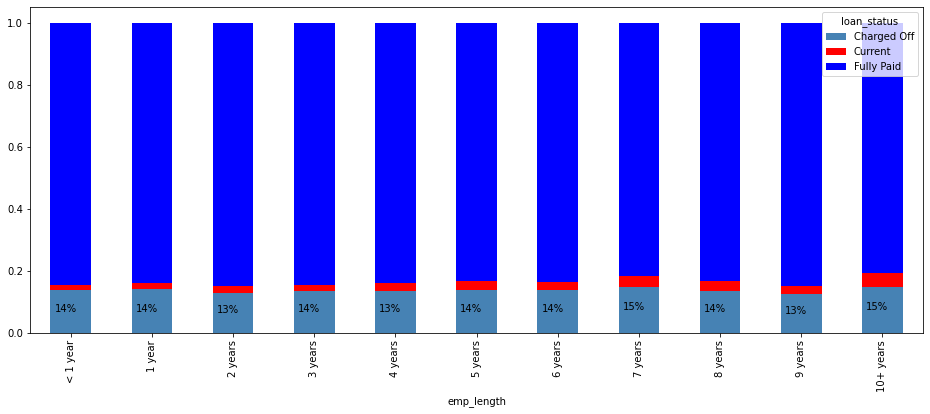

In [65]:
#create stacked bar chart

axes = crosstab_emplen_status.set_index('emp_length').plot(kind='bar', stacked=True, color=['steelblue', 'red', 'blue'])

# extract the figure object
fig = axes.get_figure()

for idx, row in crosstab_emplen_status.iterrows():
    plt.text(idx-.2, row['Charged Off']/2, "{:.0%}".format(row['Charged Off']))
    
fig.set_size_inches((16, 6))
plt.show()

Insights:
+ Employment length has little to no variation across Loan status, indicating that there is no affect of employment length on defaulting

### Check the distribution of home_ownership

In [66]:
ho_dist = get_category_distribution(loan_data, 'home_ownership', 'perc_loans', normalize=True, order=None)
ho_dist.head(2)

,home_ownership,perc_loans
0,RENT,0.475842
1,MORTGAGE,0.444621


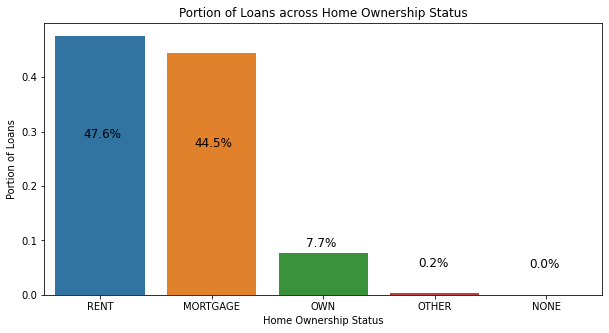

In [67]:
# bar plot

fig, axs = plt.subplots(1, 1)

sns.barplot(x='home_ownership', y='perc_loans', data=ho_dist, ax=axs)

plt.xlabel('Home Ownership Status')
plt.ylabel('Portion of Loans')
plt.title("Portion of Loans across Home Ownership Status")

for idx, row in ho_dist.iterrows():
    plt.text(idx-.15, row['perc_loans']/2 + 0.05, "{:.1%}".format(row['perc_loans']), fontdict=dict(size='large'))
    
fig.set_size_inches((10, 5))
plt.show()

Note:
+ Most of the customers are living on Rent (47.6%)
+ About 44.5% of the customers have mortgage home
+ Only 7.7% of the customers have their own homes

### <font color='green'> Bivariate Analysis: Home Ownership vs. Loan Status </font>

In [68]:
crosstab_ho_status = pd.crosstab(index=loan_data['home_ownership'], columns=loan_data['loan_status'], normalize=0).reset_index()
crosstab_ho_status.head(2)

loan_status,home_ownership,Charged Off,Current,Fully Paid
0,MORTGAGE,0.131774,0.036129,0.832097
1,NONE,0.000000,0.000000,1.000000


In [69]:
crosstab_ho_status = crosstab_ho_status[crosstab_ho_status['home_ownership'].isin(['OTHER', 'NONE']) == False].reset_index(drop=True)
crosstab_ho_status

loan_status,home_ownership,Charged Off,Current,Fully Paid
0,MORTGAGE,0.131774,0.036129,0.832097
1,OWN,0.144866,0.027142,0.827992
2,RENT,0.150220,0.022170,0.827610


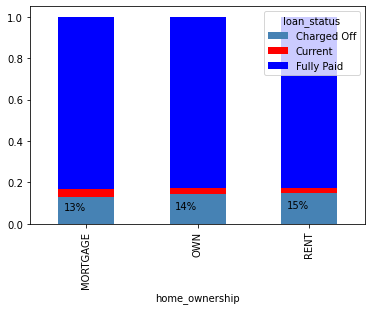

In [70]:
#create stacked bar chart

axes = crosstab_ho_status.set_index('home_ownership').plot(kind='bar', stacked=True, color=['steelblue', 'red', 'blue'])

# extract the figure object
fig = axes.get_figure()

for idx, row in crosstab_ho_status.iterrows():
    plt.text(idx-.2, row['Charged Off']/2, "{:.0%}".format(row['Charged Off']))

plt.show()

Insights:
+ "Mortgage" type home owners have slightly lower default rate

### Check the distribution of annual_inc

Insights:
+ There are outlier in the annual income, there are a very few customers with income in millions

In [71]:
loan_data['annual_inc'].describe(percentiles=np.linspace(0, 1, 11).tolist()+[.95, .99])

count    3.971700e+04
mean     6.896893e+04
std      6.379377e+04
min      4.000000e+03
0%       4.000000e+03
10%      3.000000e+04
20%      3.750000e+04
30%      4.500000e+04
40%      5.040000e+04
50%      5.900000e+04
60%      6.584440e+04
70%      7.560000e+04
80%      9.000000e+04
90%      1.160000e+05
95%      1.420000e+05
99%      2.349994e+05
100%     6.000000e+06
max      6.000000e+06
Name: annual_inc, dtype: float64

In [72]:
# removing the outliers - removing anything which is above 99%ile
inc_99ptile = np.percentile(loan_data['annual_inc'], q=99)
print("Income at 99%ile is: {:,}".format(inc_99ptile))

print("\nNumber of records in the data before removing outliers: {:,}".format(loan_data.shape[0]))

# keep values which are less than or equal to 99%ile
loan_data = loan_data[loan_data['annual_inc'] <= inc_99ptile]

print("\nNumber of records in the data after removing outliers: {:,}".format(loan_data.shape[0]))

Income at 99%ile is: 234,999.36

Number of records in the data before removing outliers: 39,717

Number of records in the data after removing outliers: 39,319


Median of Annual income is: 58000.00


C:\Users\prate\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


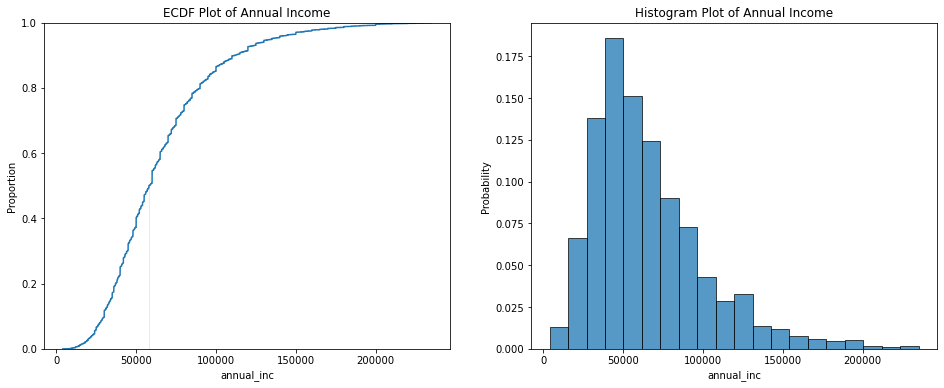

In [73]:
fig, axs = plt.subplots(1,2)

median = loan_data['annual_inc'].median()
print("Median of Annual income is: {:.2f}".format(median))

# get ecdf plot
sns.ecdfplot(loan_data['annual_inc'], ax=axs[0])
sns.lineplot([median, median], [0, 0.5], ax=axs[0])
axs[0].set_title('ECDF Plot of Annual Income')

# get histogram plot
sns.histplot(loan_data['annual_inc'], bins=20, stat='probability', ax=axs[1])
axs[1].set_title('Histogram Plot of Annual Income')

fig.set_size_inches((16, 6))
plt.show()

Insights:
+ Minimum annual income is 4,000
+ About 50% of the customers have annual income less than or equal to 58,000
+ Highest income customer is earning 6M annually and 234K post outlier removal

### <font color='green'> Segmented Analysis: Annual Income vs. Loan Status </font>

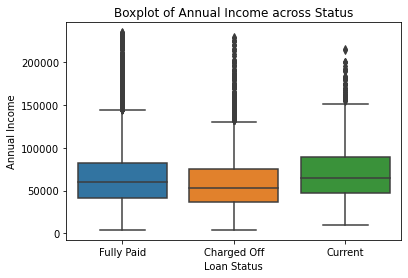

In [74]:
boxplot(loan_data, 'loan_status', 'annual_inc', 'Loan Status', 'Annual Income', 'Boxplot of Annual Income across Status')

In [75]:
loan_data.groupby('loan_status').agg({'annual_inc': 'median'}).rename(columns={'annual_inc': 'Median Annual Income'})

,Median Annual Income
loan_status,
Charged Off,52800.0
Current,64695.0
Fully Paid,60000.0


In [76]:
(52800.0 - 60000.0) / 60000.0 * 100

-12.0

In [77]:
(64695.0 - 60000.0) / 60000.0 * 100

7.825

Insights:
+ Borrowers with Charged-Off loans status, have 12% lower median Annual Income as compared to Fully-Paid borrowers
+ Current borrowers have higher median annual income than, Fully-Paid, so, these borrowers may not default

### Check the distribution of verification_status

In [78]:
vs_dist = get_category_distribution(loan_data, 'verification_status', 'perc_loans', normalize=True, order=None)
vs_dist.head(2)

,verification_status,perc_loans
0,Not Verified,0.428063
1,Verified,0.321092


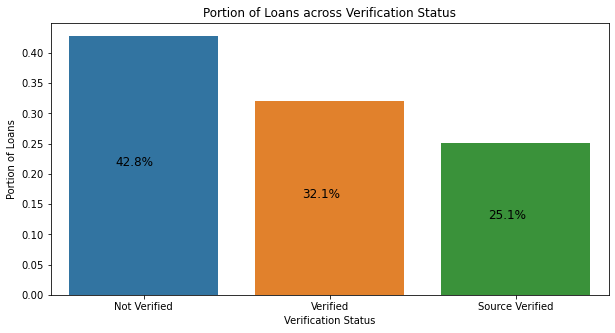

In [79]:
# bar plot

fig, axs = plt.subplots(1, 1)

sns.barplot(x='verification_status', y='perc_loans', data=vs_dist, ax=axs)

plt.xlabel('Verification Status')
plt.ylabel('Portion of Loans')
plt.title("Portion of Loans across Verification Status")

for idx, row in vs_dist.iterrows():
    plt.text(idx-.15, row['perc_loans']/2, "{:.1%}".format(row['perc_loans']), fontdict=dict(size='large'))
    
fig.set_size_inches((10, 5))
plt.show()

+ In about 43% of Loan applications, income of the customer is not verified.

### <font color='green'> Bivariate Analysis: Verification Status vs. Loan Status </font>

In [80]:
crosstab_vs_status = pd.crosstab(index=loan_data['verification_status'], columns=loan_data['loan_status'], normalize=0).reset_index()
crosstab_vs_status

loan_status,verification_status,Charged Off,Current,Fully Paid
0,Not Verified,0.126552,0.013487,0.859961
1,Source Verified,0.144175,0.031025,0.824800
2,Verified,0.160950,0.046970,0.792079


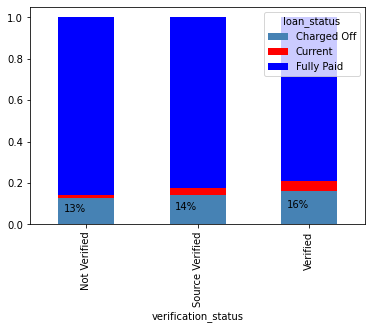

In [81]:
#create stacked bar chart
crosstab_vs_status.set_index('verification_status').plot(kind='bar', stacked=True, color=['steelblue', 'red', 'blue'])

for idx, row in crosstab_vs_status.iterrows():
    plt.text(idx-.2, row['Charged Off']/2, "{:.0%}".format(row['Charged Off']))

plt.show()

Insights:
+ "Not Verified" loans have lowest (13%) Charged-off status, while "Verified" has the highest of 16%

### Check the distribution of issue_d

In [82]:
# convert issue date to datetime format
loan_data['issue_month_year'] = loan_data['issue_d'].apply(lambda x: datetime.strptime(x, '%b-%y'))

In [83]:
monthly_loans_issued = get_category_distribution(loan_data, 'issue_month_year', 'num_loans', normalize=False, order='issue_month_year')
monthly_loans_issued.head(2)

,issue_month_year,num_loans
0,2007-06-01,0.000025
1,2007-07-01,0.000738


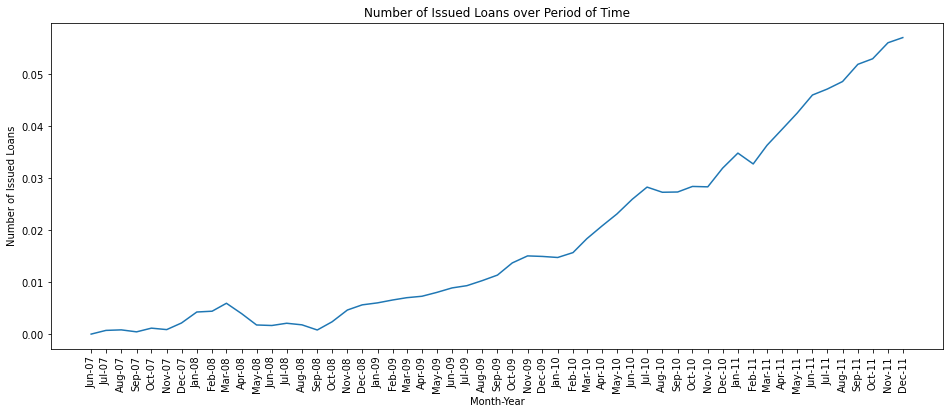

In [84]:
fig, ax = plt.subplots(1,1)

sns.lineplot(x='issue_month_year', y='num_loans', data=monthly_loans_issued, ax=ax)
ax.set(xticks=monthly_loans_issued['issue_month_year'].values)
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b-%y'))
plt.xticks(rotation=90)

plt.xlabel('Month-Year')
plt.ylabel('Number of Issued Loans')
plt.title("Number of Issued Loans over Period of Time")

fig.set_size_inches((16, 6))
plt.show()

+ After October of 2008, the number of loans issued kept on growing, with highest loan being issued in Dec of 2011

### Check desc variable

In [85]:
# display 10 titles
for idx, val in enumerate(loan_data['desc']):
    print(val)
    if idx>=5: break

  Borrower added on 12/22/11 > I need to upgrade my business technologies.<br>
  Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike. I only need this money because the deal im looking at is to good to pass up.<br><br>  Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike.I only need this money because the deal im looking at is to good to pass up. I have finished college with an associates degree in business and its takingmeplaces<br>
nan
  Borrower added on 12/21/11 > to pay for property tax (borrow from friend, need to pay back) & central A/C need to be replace. I'm very sorry to let my loan expired last time.<br>
  Borrower added on 12/21/11 > I plan on combining three large interest bills together and freeing up some extra each month to pay toward other b

+ There are a lot of stopwords like 'borrower' and 'added' which needs to be removed

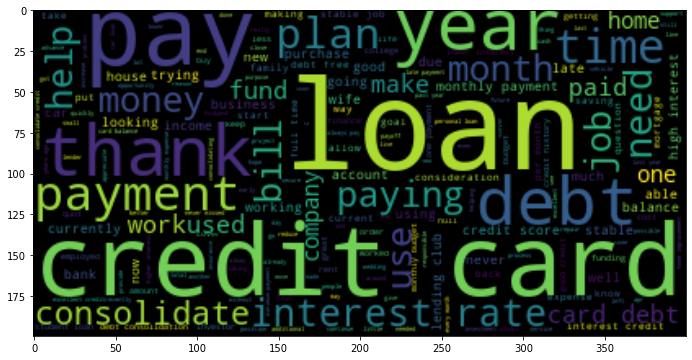

In [86]:
# get the text for word cloud
text = " ".join(loan_data[loan_data['desc'].isnull() == False]['desc']).lower()

# add stopwords
desc_stopwords = list(STOPWORDS) + ['borrower', 'added', 'br', 'on', 'want', 'will']

# plot the word cloud
fig, axs = plt.subplots(1, 1)
cloud = WordCloud(max_words=200, stopwords=set(desc_stopwords) )
cloud.generate(text)
fig.set_size_inches((16, 6))
plt.imshow(cloud, interpolation='bilinear')

Note:
+ Looks like people need loan for payment of their current debts - "loan", "payment", "credit card", "etc."

### <font color='red'> Data Driven Derived variable: boolean, whether description is provided or not </font>

In [87]:
# create the variable
loan_data['is_desc'] = loan_data['desc'].apply(lambda x: not pd.isna(x))

# check the distribution of desc availability
loan_data['is_desc'].value_counts(normalize=True)

True     0.674203
False    0.325797
Name: is_desc, dtype: float64

<font color='blue' size=4> compare is_desc with loan_status:</font> to check if there is any relationship between the two

In [88]:
crosstab_desc_status = pd.crosstab(index=loan_data['is_desc'], columns=loan_data['loan_status'], normalize=0).reset_index()
crosstab_desc_status

loan_status,is_desc,Charged Off,Current,Fully Paid
0,False,0.139657,0.031850,0.828493
1,True,0.143159,0.027085,0.829756


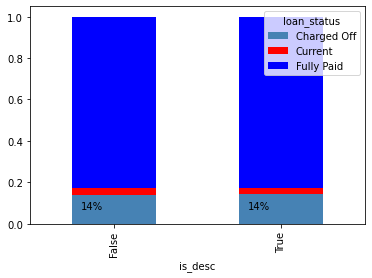

In [89]:
#create stacked bar chart
crosstab_desc_status.set_index('is_desc').plot(kind='bar', stacked=True, color=['steelblue', 'red', 'blue'])

for idx, row in crosstab_desc_status.iterrows():
    plt.text(idx-.2, row['Charged Off']/2, "{:.0%}".format(row['Charged Off']))

plt.show()

Insights:
+ About 14% of Charged off borrowers did not provide loan description. Which, is similar to Fully-paid customers, hence we could not establish any relationship between loan default based on description provided

### Check the distribution of purpose

In [90]:
purpose_dist = get_category_distribution(loan_data, 'purpose', 'perc_loans', normalize=True, order=None)
purpose_dist.head(2)

,purpose,perc_loans
0,debt_consolidation,0.470434
1,credit_card,0.129429


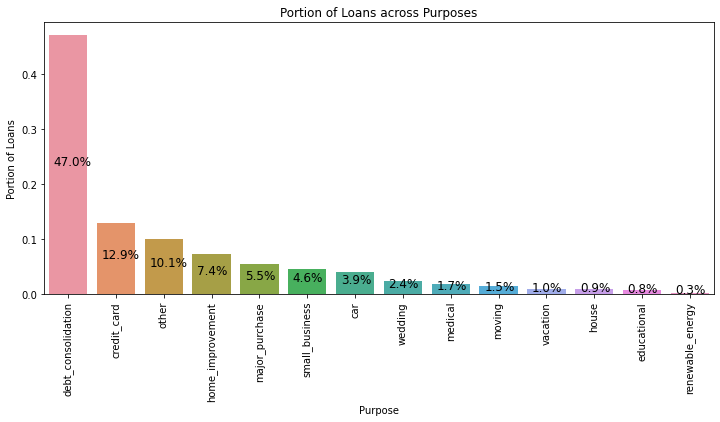

In [91]:
# bar plot

fig, axs = plt.subplots(1, 1)

sns.barplot(x='purpose', y='perc_loans', data=purpose_dist, ax=axs)

plt.xlabel('Purpose')
plt.xticks(rotation=90)
plt.ylabel('Portion of Loans')
plt.title("Portion of Loans across Purposes")

for idx, row in purpose_dist.iterrows():
    plt.text(idx-.3, row['perc_loans']/2, "{:.1%}".format(row['perc_loans']), fontdict=dict(size='large'))
    
fig.set_size_inches((12, 5))
plt.show()

Insights:
+ Majority of the loans (47%) had "Debt Consolidation" category
+ While, very small portion of loans belong to "Vacation", "House", "Educational" or "Renewable Energy"

### <font color='green'> Bivariate Analysis: purpose vs. Loan Status </font>

In [92]:
crosstab_purpose_status = pd.crosstab(index=loan_data['purpose'], columns=loan_data['loan_status'], normalize=0).reset_index()
crosstab_purpose_status

loan_status,purpose,Charged Off,Current,Fully Paid
0,car,0.103761,0.032425,0.863813
1,credit_card,0.105522,0.020043,0.874435
2,debt_consolidation,0.148781,0.031356,0.819863
3,educational,0.170279,0.000000,0.829721
4,home_improvement,0.116793,0.033518,0.849689
5,house,0.156334,0.037736,0.805930
6,major_purchase,0.101570,0.017082,0.881348
7,medical,0.154519,0.017493,0.827988
8,moving,0.157712,0.012132,0.830156
9,other,0.158919,0.031834,0.809247


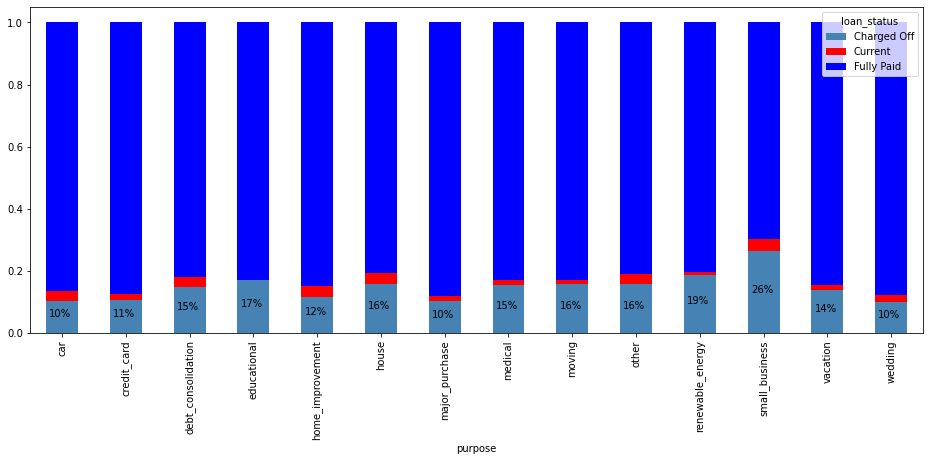

In [93]:
#create stacked bar chart

axes = crosstab_purpose_status.set_index('purpose').plot(kind='bar', stacked=True, color=['steelblue', 'red', 'blue'])

# extract the figure object
fig = axes.get_figure()

for idx, row in crosstab_purpose_status.iterrows():
    plt.text(idx-.2, row['Charged Off']/2, "{:.0%}".format(row['Charged Off']))
    
fig.set_size_inches((16, 6))
plt.show()

Insights:
+ "Small Business" purpose has the highest defaults of 26%, followed by "Renewable Energy" with 19% Charge-Offs
+ "Car" & "Wedding" purposes have the lowest Charge-Offs of 10%

### Check the distribution of zip_codes

### Check the distribution of addr_state

In [94]:
state_dist = get_category_distribution(loan_data, 'addr_state', 'perc_loans', normalize=True, order='addr_state')
state_dist.head(2)

,addr_state,perc_loans
0,AK,0.002009
1,AL,0.011419


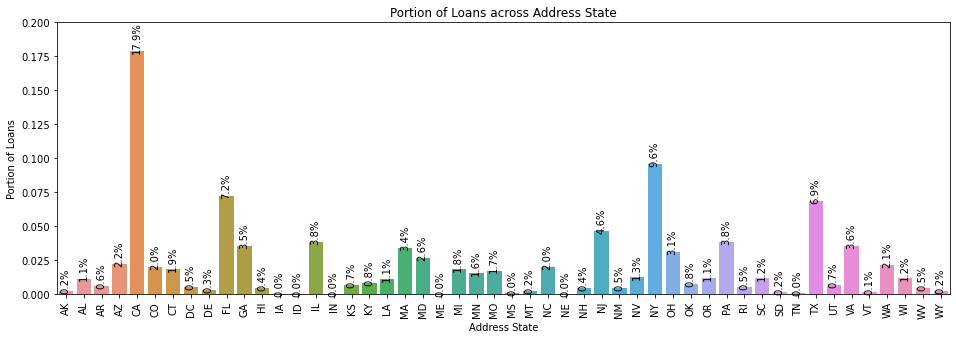

In [95]:
# bar plot

fig, axs = plt.subplots(1, 1)

sns.barplot(x='addr_state', y='perc_loans', data=state_dist, ax=axs)

plt.xlabel('Address State')
plt.xticks(rotation=90)
plt.ylabel('Portion of Loans')
plt.ylim(0, 0.2)
plt.title("Portion of Loans across Address State")

for idx, row in state_dist.iterrows():
    plt.text(idx-.3, row['perc_loans'], "{:.1%}".format(row['perc_loans']), fontdict=dict(size='medium'), rotation=90)
    
fig.set_size_inches((16, 5))
plt.show()

Insights:
+ California has the highest percentage of loans 18%, followed by New-York 10% 

### <font color='green'> Segmented Analysis: States vs. Loan Status </font>

In [96]:
crosstab_state_status = pd.crosstab(index=loan_data['addr_state'], columns=loan_data['loan_status'], normalize=0).reset_index()
crosstab_state_status.head(2)

loan_status,addr_state,Charged Off,Current,Fully Paid
0,AK,0.177215,0.025316,0.797468
1,AL,0.120267,0.037862,0.841871


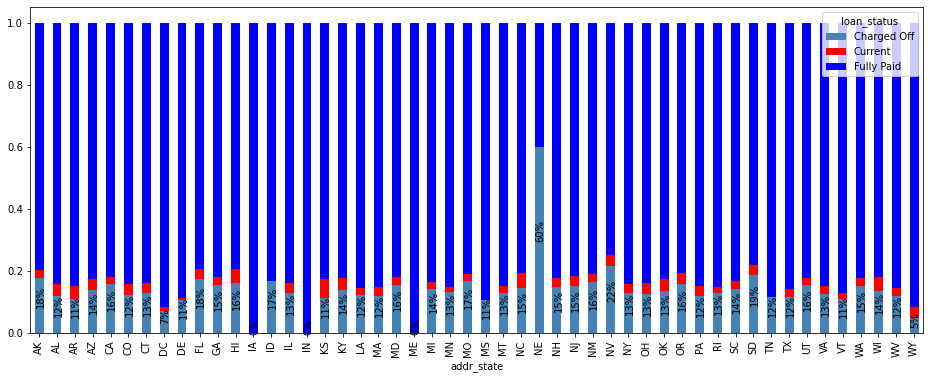

In [97]:
#create stacked bar chart

axes = crosstab_state_status.set_index('addr_state').plot(kind='bar', stacked=True, color=['steelblue', 'red', 'blue'])

# extract the figure object
fig = axes.get_figure()

for idx, row in crosstab_state_status.iterrows():
    plt.text(idx-.2, row['Charged Off']/2, "{:.0%}".format(row['Charged Off']), rotation=90)
    
fig.set_size_inches((16, 6))
plt.show()

Insights:
+ NE/Nebarask has the highest percentage of Charged-Off, but, only 3 loans are provided there
+ NV/Nevada has the second highest percentage of Charged-Off (22%)

### Check the distribution of dti

Median of DTI is: 13.48


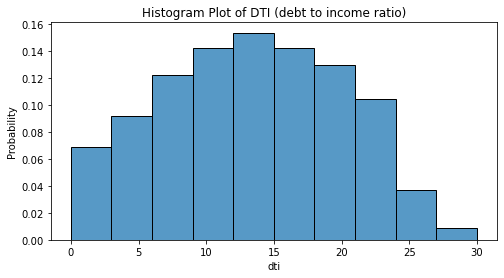

In [98]:
fig, axs = plt.subplots(1,1)

median = loan_data['dti'].median()
print("Median of DTI is: {:.2f}".format(median))

# get histogram plot
sns.histplot(loan_data['dti'], bins=10, stat='probability', ax=axs)
axs.set_title('Histogram Plot of DTI (debt to income ratio)')

fig.set_size_inches((8, 4))
plt.show()

### <font color='green'> Segmented Analysis: DTI vs. Loan Status </font>

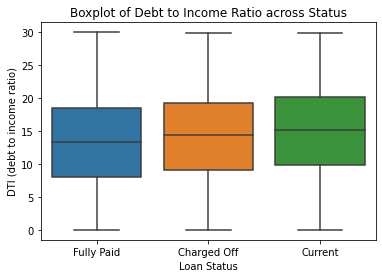

In [99]:
boxplot(loan_data, 'loan_status', 'dti', 'Loan Status', 'DTI (debt to income ratio)', 'Boxplot of Debt to Income Ratio across Status')

In [100]:
loan_data.groupby('loan_status').agg({'dti': 'median'})

,dti
loan_status,
Charged Off,14.340
Current,15.105
Fully Paid,13.270


In [101]:
(14.34 - 13.27) / 13.27 * 100

8.063300678221555

Insights:
+ Median DTI is 8% higher for Charged-Off than Fully-Paid

### Check the distribution of delinq_2yrs

In [102]:
delinq_dist = get_category_distribution(loan_data, 'delinq_2yrs', 'perc_loans', normalize=True, order='delinq_2yrs')
delinq_dist.head(2)

,delinq_2yrs,perc_loans
0,0,0.892088
1,1,0.082784


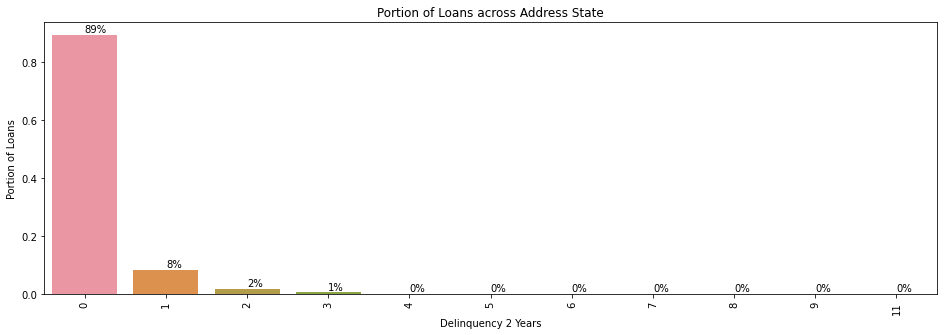

In [103]:
# bar plot

fig, axs = plt.subplots(1, 1)

sns.barplot(x='delinq_2yrs', y='perc_loans', data=delinq_dist, ax=axs)

plt.xlabel('Delinquency 2 Years')
plt.xticks(rotation=90)
plt.ylabel('Portion of Loans')
plt.title("Portion of Loans across Address State")

for idx, row in delinq_dist.iterrows():
    plt.text(idx, row['perc_loans']+0.01, "{:.0%}".format(row['perc_loans']), fontdict=dict(size='medium'))
    
fig.set_size_inches((16, 5))
plt.show()

Insights:
+ 90% of borrowers have not made any delinquency
+ 8.3% made 1 delinquency

### <font color='green'> Bivariate Analysis: Delinquency 2 Years vs. Loan Status </font>

In [104]:
crosstab_delinq_status = pd.crosstab(index=loan_data['delinq_2yrs'], columns=loan_data['loan_status'], normalize=0).reset_index()
crosstab_delinq_status.head(2)

loan_status,delinq_2yrs,Charged Off,Current,Fully Paid
0,0,0.139668,0.028709,0.831623
1,1,0.154531,0.028879,0.816590


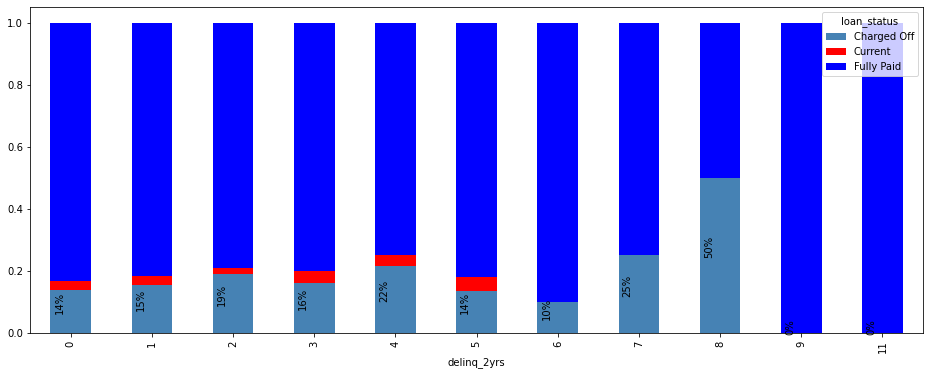

In [105]:
#create stacked bar chart

axes = crosstab_delinq_status.set_index('delinq_2yrs').plot(kind='bar', stacked=True, color=['steelblue', 'red', 'blue'])

# extract the figure object
fig = axes.get_figure()

for idx, row in crosstab_delinq_status.iterrows():
    plt.text(idx-.2, row['Charged Off']/2, "{:.0%}".format(row['Charged Off']), rotation=90)
    
fig.set_size_inches((16, 6))
plt.show()

Insights:
+ Loans with '0' delinquency has the lowest Charge-Off, as compared to 1, 2, 3 & 4 delinquencies (rest are very small)

### Check the distribution of earliest_cr_line

In [106]:
# convert issue date to datetime format
loan_data['earliest_cr_line_year'] = loan_data['earliest_cr_line'].apply(lambda x: datetime.strptime(x, '%b-%y').year)

In [107]:
# Check if all values are fine
min(loan_data['earliest_cr_line_year']), max(loan_data['earliest_cr_line_year'])

(1969, 2068)

In [108]:
print("Number of records before dropping nulls: {:,}".format(loan_data.shape[0]))
loan_data = loan_data[loan_data['earliest_cr_line_year'] <= 2011]
print("\nNumber of records after dropping nulls: {:,}".format(loan_data.shape[0]))

Number of records before dropping nulls: 39,319

Number of records after dropping nulls: 39,232


In [109]:
monthly_loans_issued = get_category_distribution(loan_data, 'earliest_cr_line_year', 'num_loans', normalize=False, order='earliest_cr_line_year')
monthly_loans_issued.head(2)

,earliest_cr_line_year,num_loans
0,1969,0.000918
1,1970,0.001223


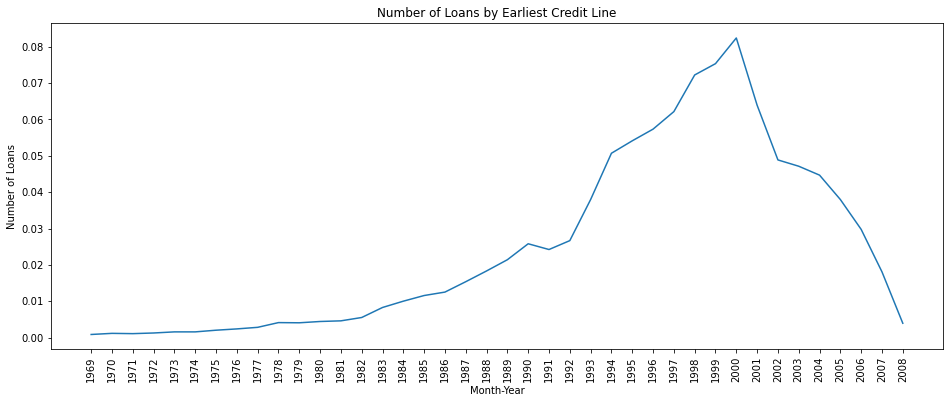

In [110]:
fig, ax = plt.subplots(1,1)

sns.lineplot(x='earliest_cr_line_year', y='num_loans', data=monthly_loans_issued, ax=ax)
ax.set(xticks=monthly_loans_issued['earliest_cr_line_year'].values)
plt.xticks(rotation=90)

plt.xlabel('Month-Year')
plt.ylabel('Number of Loans')
plt.title("Number of Loans by Earliest Credit Line")

fig.set_size_inches((16, 6))
plt.show()

Insights:
+ Maximum number of borrowers took their first loan at the end of 2000's

### Check the distribution of inq_last_6mths

In [111]:
inqs_dist = get_category_distribution(loan_data, 'inq_last_6mths', 'perc_loans', normalize=True, order='inq_last_6mths')
inqs_dist.head(2)

,inq_last_6mths,perc_loans
0,0,0.486363
1,1,0.276356


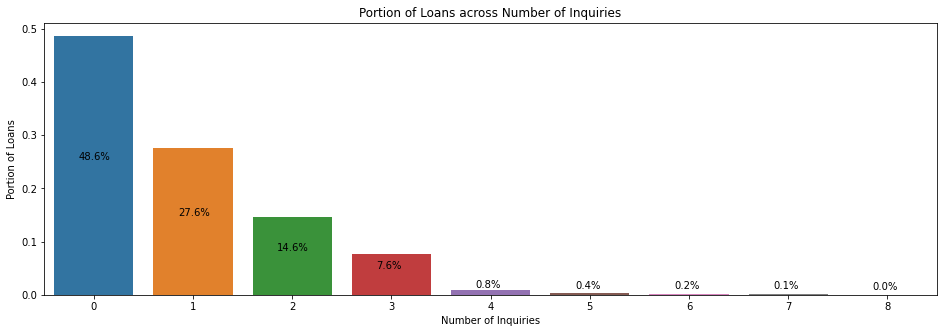

In [112]:
# bar plot

fig, axs = plt.subplots(1, 1)

sns.barplot(x='inq_last_6mths', y='perc_loans', data=inqs_dist, ax=axs)

plt.xlabel('Number of Inquiries')
plt.ylabel('Portion of Loans')
plt.title("Portion of Loans across Number of Inquiries")

for idx, row in inqs_dist.iterrows():
    plt.text(idx-.15, row['perc_loans']/2+0.01, "{:.1%}".format(row['perc_loans']), fontdict=dict(size='medium'))
    
fig.set_size_inches((16, 5))
plt.show()

Insights:
+ 47% of the loans had no inquiries made
+ Only 1.4% of the loans had more than 3 inquiries

### <font color='green'> Bivariate Analysis: Inquiries in Last 6months vs. Loan Status </font>

In [113]:
crosstab_inq_status = pd.crosstab(index=loan_data['inq_last_6mths'], columns=loan_data['loan_status'], normalize=0).reset_index()
crosstab_inq_status.head(2)

loan_status,inq_last_6mths,Charged Off,Current,Fully Paid
0,0,0.117971,0.030397,0.851633
1,1,0.152832,0.028039,0.819129


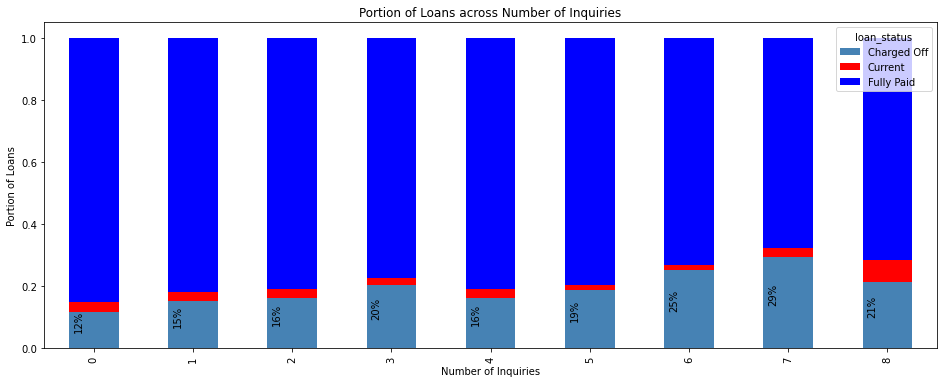

In [114]:
#create stacked bar chart

axes = crosstab_inq_status.set_index('inq_last_6mths').plot(kind='bar', stacked=True, color=['steelblue', 'red', 'blue'])

# extract the figure object
fig = axes.get_figure()

for idx, row in crosstab_inq_status.iterrows():
    plt.text(idx-.2, row['Charged Off']/2, "{:.0%}".format(row['Charged Off']), rotation=90)


plt.xlabel('Number of Inquiries')
plt.ylabel('Portion of Loans')
plt.title("Portion of Loans across Number of Inquiries")

fig.set_size_inches((16, 6))
plt.show()

Insights:
+ Loans where more inquiries were made had higher percentage of Charge-Offs
+ Proportion of Charge offs in 8 inquiries are less as compared to 6 & 7

### Check the distribution of mths_since_last_delinq

### <font color='red'> Data Driven Derived variable: boolean, whether description is provided or not </font>

In [115]:
# check nulls, if in such records loans were fully-paid or not
loan_data['is_last_delinq_null'] = loan_data['mths_since_last_delinq'].apply(lambda x: np.isnan(x))
loan_data['is_last_delinq_null'].value_counts(normalize=True)

True     0.647099
False    0.352901
Name: is_last_delinq_null, dtype: float64

In [116]:
crosstab_delinq_null_status = pd.crosstab(index=loan_data['is_last_delinq_null'], columns=loan_data['loan_status'], normalize=0).reset_index()
crosstab_delinq_null_status

loan_status,is_last_delinq_null,Charged Off,Current,Fully Paid
0,False,0.153124,0.025858,0.821018
1,True,0.135818,0.030055,0.834128


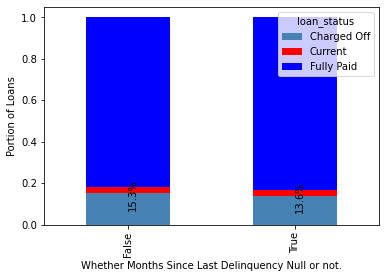

In [117]:
#create stacked bar chart

axes = crosstab_delinq_null_status.set_index('is_last_delinq_null').plot(kind='bar', stacked=True, color=['steelblue', 'red', 'blue'])

# extract the figure object
fig = axes.get_figure()

for idx, row in crosstab_delinq_null_status.iterrows():
    plt.text(idx, row['Charged Off']/2, "{:.1%}".format(row['Charged Off']), rotation=90)

plt.xlabel('Whether Months Since Last Delinquency Null or not.')
plt.ylabel('Portion of Loans')

fig.set_size_inches((6, 4))
plt.show()

Insights:
+ Nulls in Months since last delinquency has nothing to do with Charge-off

#### Check Nulls in mths_since_last_delinq against delinq_2yrs

In [118]:
loan_data[loan_data['is_last_delinq_null']]['delinq_2yrs'].value_counts(normalize=True)

0    1.0
Name: delinq_2yrs, dtype: float64

Insights:
+ All the nulls in mnths_since_last_delinq has 0 delinquencies in last 2 years
+ So, it can be imputed as 0

In [119]:
loan_data[loan_data['is_last_delinq_null']]['mths_since_last_delinq'] = 0

<ipython-input-119-127c926f65af>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data[loan_data['is_last_delinq_null']]['mths_since_last_delinq'] = 0


### Check the distribution of mths_since_last_record

In [120]:
# number of nulls
print("Number of nulls: {:,}".format(loan_data['mths_since_last_record'].isnull().sum()))

Number of nulls: 36,474


In [121]:
# check what values are in pub_rec against null values
loan_data[loan_data['mths_since_last_record'].isnull()]['pub_rec'].unique()

array([0], dtype=int64)

In [122]:
# impute values with 0
loan_data[loan_data['mths_since_last_record'].isnull()]['mths_since_last_record'] = 0

<ipython-input-122-2e8e4e65f9c6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data[loan_data['mths_since_last_record'].isnull()]['mths_since_last_record'] = 0


### Check the distribution of open_acc

Median of open_acc is: 9.00


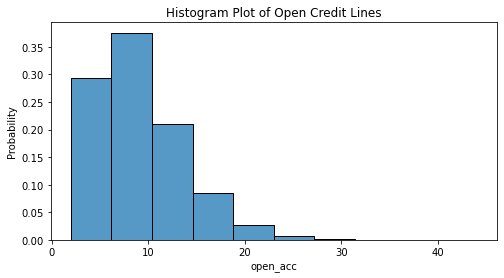

In [123]:
fig, axs = plt.subplots(1,1)

median = loan_data['open_acc'].median()
print("Median of open_acc is: {:.2f}".format(median))

# get histogram plot
sns.histplot(loan_data['open_acc'], bins=10, stat='probability', ax=axs)
axs.set_title('Histogram Plot of Open Credit Lines')

fig.set_size_inches((8, 4))
plt.show()

### <font color='green'> Segmented Analysis: Open Credit Lines vs. Loan Status </font>

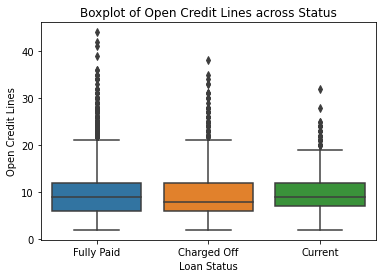

In [124]:
boxplot(loan_data, 'loan_status', 'open_acc', 'Loan Status', 'Open Credit Lines', 'Boxplot of Open Credit Lines across Status')

In [125]:
loan_data.groupby('loan_status').agg({'open_acc': 'median'})

,open_acc
loan_status,
Charged Off,8
Current,9
Fully Paid,9


Insights:
+ Charged-off customers have lower median open credit lines

### Check the distribution of revol_bal

Median of revol_bal is: 8800.00


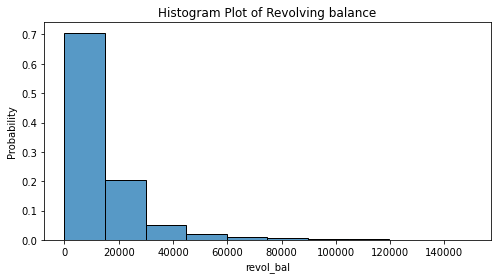

In [126]:
fig, axs = plt.subplots(1,1)

median = loan_data['revol_bal'].median()
print("Median of revol_bal is: {:.2f}".format(median))

# get histogram plot
sns.histplot(loan_data['revol_bal'], bins=10, stat='probability', ax=axs)
axs.set_title('Histogram Plot of Revolving balance')

fig.set_size_inches((8, 4))
plt.show()

### Check the distribution of revol_util

In [127]:
# Fix revol_util column, i.e. remove % sign
loan_data['revol_util'] = loan_data['revol_util'].apply(lambda x: float(str(x).strip('% ')))
loan_data['revol_util'].describe()

count    39183.000000
mean        48.845911
std         28.300664
min          0.000000
25%         25.500000
50%         49.300000
75%         72.350000
max         99.900000
Name: revol_util, dtype: float64

Median of revol_bal is: 49.30


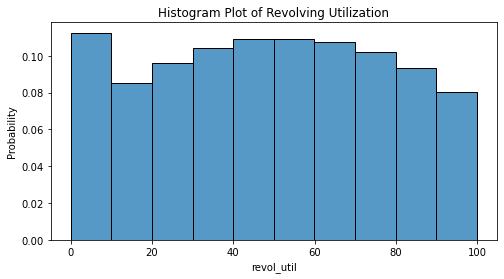

In [128]:
fig, axs = plt.subplots(1,1)

median = loan_data['revol_util'].median()
print("Median of revol_bal is: {:.2f}".format(median))

# get histogram plot
sns.histplot(loan_data['revol_util'], bins=10, stat='probability', ax=axs)
axs.set_title('Histogram Plot of Revolving Utilization')

fig.set_size_inches((8, 4))
plt.show()

### <font color='green'> Segmented Analysis: Revolving Utilization vs. Loan Status </font>

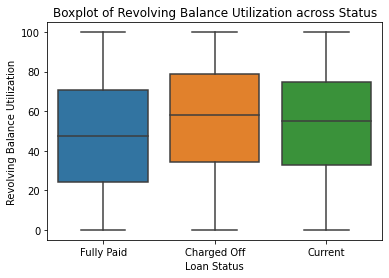

In [129]:
boxplot(loan_data, 'loan_status', 'revol_util', 'Loan Status', 'Revolving Balance Utilization', 'Boxplot of Revolving Balance Utilization across Status')

In [130]:
loan_data.groupby('loan_status').agg({'revol_util': 'median'}).rename(columns={'revol_util': '% Revolving Utilization'})

,% Revolving Utilization
loan_status,
Charged Off,58.3
Current,55.0
Fully Paid,47.6


In [131]:
(58.3 - 55)/55 * 100

5.999999999999995

In [132]:
(47.6 - 55)/55 * 100

-13.454545454545453

Insights:
+ Median Revolving Utilization for Charged-Off borrowers is 6% higher than Fully-paid borrowers

### Check the distribution of total_acc

Median of revol_bal is: 20.00


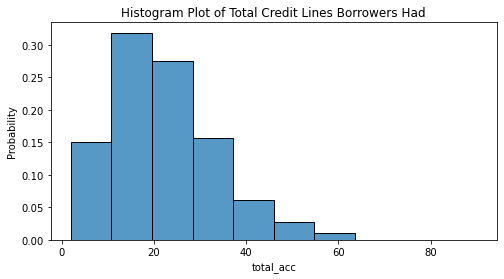

In [133]:
fig, axs = plt.subplots(1,1)

median = loan_data['total_acc'].median()
print("Median of revol_bal is: {:.2f}".format(median))

# get histogram plot
sns.histplot(loan_data['total_acc'], bins=10, stat='probability', ax=axs)
axs.set_title('Histogram Plot of Total Credit Lines Borrowers Had')

fig.set_size_inches((8, 4))
plt.show()

Insights:
+ There are high percentage of borrowers have very high number of credit lines

### <font color='green'> Segmented Analysis: Total Accounts vs. Loan Status </font>

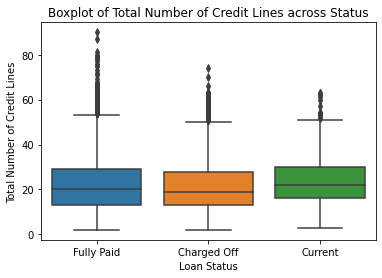

In [134]:
boxplot(loan_data, 'loan_status', 'total_acc', 'Loan Status', 'Total Number of Credit Lines', 'Boxplot of Total Number of Credit Lines across Status')

In [135]:
loan_data.groupby('loan_status').agg({'total_acc': 'median'})

,total_acc
loan_status,
Charged Off,19
Current,22
Fully Paid,20


Insights:
+ Charged-off borrowers had lowest median credit lines of 19, while Fully-paid borrowers had 20

### <font color='red'> Business Driven Derived variable: Ratio of  total_pymnt and funded_amnt</font>
To check what percentage of payment has been recovered by Charged-off borrowers

In [136]:
loan_data['total_pymnt_to_loan_amnt'] = loan_data['total_pymnt'] / loan_data['funded_amnt']

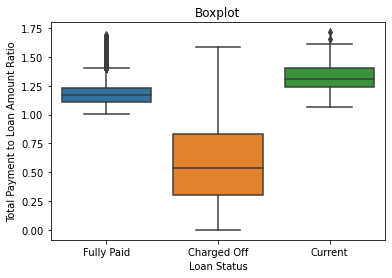

In [137]:
boxplot(loan_data, 'loan_status', 'total_pymnt_to_loan_amnt', 'Loan Status', 'Total Payment to Loan Amount Ratio', 'Boxplot')

Insights:
+ For both Fully-paid and Current customers, more money have been received than the principal amount, which is due to the interest rates.
+ More than 50% of the Fully-paid borrowers have returned more than 125% of the principal/funded amount
+ While, 50% of Charged-off customers have not even returned 50%of the funded amount

### <font color='red'> Business Driven Derived variable: Ratio of  total_rec_prncp and funded_amnt</font>
To check what percentage of principal payment has been recovered by Charged-off borrowers

In [138]:
loan_data['total_rec_prncp_to_loan_amnt'] = loan_data['total_rec_prncp'] / loan_data['funded_amnt']

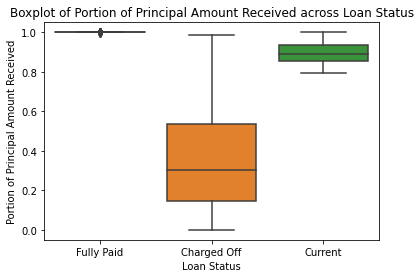

In [139]:
boxplot(loan_data, 'loan_status', 'total_rec_prncp_to_loan_amnt', 'Loan Status', 'Portion of Principal Amount Received', 'Boxplot of Portion of Principal Amount Received across Loan Status')

Insights:
+ Current status borrowers have already returned 80% of the principal amount
+ About 50% of the Charged-Off borrowers have return less than 30% of the principal amount

### <font color='green'> Segmented Analysis: total_rec_late_fee vs. Loan Status </font>

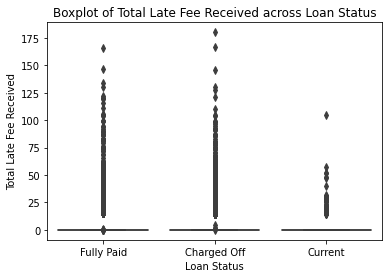

In [140]:
boxplot(loan_data, 'loan_status', 'total_rec_late_fee', 'Loan Status', 'Total Late Fee Received', 'Boxplot of Total Late Fee Received across Loan Status')

Note: Contains outliers

In [141]:
loan_data['total_rec_late_fee'].describe(percentiles=[.75, .90, .92, .94, .95, .99])

count    39232.000000
mean         1.361044
std          7.285546
min          0.000000
50%          0.000000
75%          0.000000
90%          0.000000
92%          0.000000
94%          0.000000
95%         14.925719
99%         33.555433
max        180.200000
Name: total_rec_late_fee, dtype: float64

Insights:
+ Only about 5% of the borrowers paid late fee

In [142]:
loan_data.groupby('loan_status')['total_rec_late_fee'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,5568.0,4.288072,12.826323,0.0,0.0,0.0,0.0,180.20
Current,1121.0,1.166029,6.345293,0.0,0.0,0.0,0.0,104.56
Fully Paid,32543.0,0.866957,5.722656,0.0,0.0,0.0,0.0,165.69


Insights:
+ On an Average Charged-Off borrowers paid $4.2 as late fee, while it is less than $1 by Fully-Paid borrowers

### Check the distribution of last_pymnt_d
+ Categorical (month-year) column with 101 distinct values
+ Most frequent is "May-16"
+ There are 71 nulls, could indicate, about 71 customers never made even a single payment

#### <font color='green'> Segmented Analysis: last_pymnt_d vs. last_pymnt_amnt </font>

In [143]:
loan_data[loan_data['last_pymnt_d'].isnull()][['total_pymnt', 'last_pymnt_amnt']].describe()

,total_pymnt,last_pymnt_amnt
count,71.000000,71.0
mean,617.712113,0.0
std,1649.735157,0.0
min,0.000000,0.0
25%,44.940000,0.0
50%,179.730000,0.0
75%,440.450000,0.0
max,12325.000000,0.0


Insights:
+ There are Loans where last_pymnt_d is missing, but, some of the amount has been paid by borrowers previously but the last_pymnt has not been received by them and this is the reason for nulls

### Check the distribution of next_pymnt_d
+ Most of the values are Null, need to CHECK why, it could be most customers cleared their loan
+ Contains 2 distinct values, need to check those
+ "Jun-16" is the most frequent (1,125 records)

In [144]:
loan_data[loan_data['next_pymnt_d'].isnull()]['loan_status'].value_counts()

Fully Paid     32543
Charged Off     5568
Name: loan_status, dtype: int64

Insights:
+ next_pymnt_d is null for borrowers who either have Fully-paid their loans or who are Charged-off

In [145]:
### Check the distribution of revol_bal

### <font color='green'> Bivariate Analysis: total_rec_int vs. loan_amnt </font>

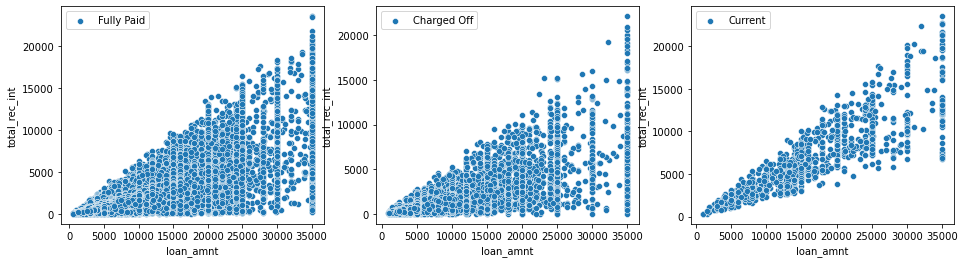

In [146]:
fig, axs = plt.subplots(1, 3)
sns.scatterplot(x='loan_amnt', y='total_rec_int', data=loan_data[loan_data['loan_status'] == 'Fully Paid'], ax=axs[0], label='Fully Paid')
sns.scatterplot(x='loan_amnt', y='total_rec_int', data=loan_data[loan_data['loan_status'] == 'Charged Off'], ax=axs[1], label='Charged Off')
sns.scatterplot(x='loan_amnt', y='total_rec_int', data=loan_data[loan_data['loan_status'] == 'Current'], ax=axs[2], label='Current')

fig.set_size_inches((16, 4))
plt.show()

### <font color='green'> Bivariate Analysis: total_rec_int vs. int_rate </font>

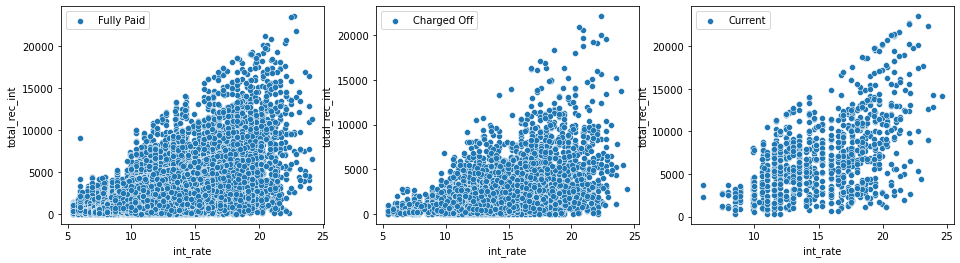

In [147]:
fig, axs = plt.subplots(1, 3)
sns.scatterplot(x='int_rate', y='total_rec_int', data=loan_data[loan_data['loan_status'] == 'Fully Paid'], ax=axs[0], label='Fully Paid')
sns.scatterplot(x='int_rate', y='total_rec_int', data=loan_data[loan_data['loan_status'] == 'Charged Off'], ax=axs[1], label='Charged Off')
sns.scatterplot(x='int_rate', y='total_rec_int', data=loan_data[loan_data['loan_status'] == 'Current'], ax=axs[2], label='Current')

fig.set_size_inches((16, 4))
plt.show()

### Check the distribution of pub_rec_bankruptcies
+ Values are in range of 0 to 2
+ But for most records it is 0
+ There are 697 Nulls, for these there could be no info available

### <font color='green'> Bivariate Analysis: pub_rec_bankruptcies vs. loan_status </font>

In [148]:
crosstab_bankrupt_status = pd.crosstab(index=loan_data['pub_rec_bankruptcies'], columns=loan_data['loan_status'], normalize=0).reset_index()
crosstab_bankrupt_status

loan_status,pub_rec_bankruptcies,Charged Off,Current,Fully Paid
0,0.0,0.137945,0.029341,0.832714
1,1.0,0.218412,0.022262,0.759326
2,2.0,0.285714,0.285714,0.428571


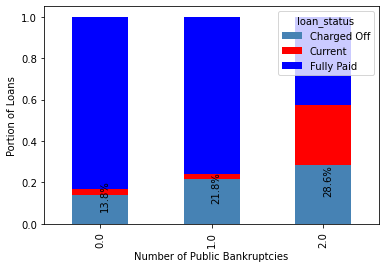

In [149]:
#create stacked bar chart

axes = crosstab_bankrupt_status.set_index('pub_rec_bankruptcies').plot(kind='bar', stacked=True, color=['steelblue', 'red', 'blue'])

# extract the figure object
fig = axes.get_figure()

for idx, row in crosstab_bankrupt_status.iterrows():
    plt.text(idx, row['Charged Off']/2, "{:.1%}".format(row['Charged Off']), rotation=90)

plt.xlabel('Number of Public Bankruptcies')
plt.ylabel('Portion of Loans')

fig.set_size_inches((6, 4))
plt.show()

Insights:
+ Borrowers with 2 public bankruptcies declared are more prone to Charge-off
+ Good percentage of customers with 2 bankruptcies are current loans, they are prone to default